In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    





/home/cd/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [1]:
### Load classifer
from sklearn.externals import joblib
#model_name = 'acc0.9875_HLS_orient9pix_per_cell8cell_per_block2spatial_size(16, 16)hist_bin32.pkl'
model_name = 'acc0.9912_YCrCb_orient9pix_per_cell8cell_per_block2spatial_size(16, 16)hist_bin32.pkl'
clf = joblib.load(model_name)
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# load scaler
import pickle
pkl_file = open('scaler_'+ model_name, 'rb')
X_scaler = pickle.load(pkl_file)

In [89]:
def multi_scale_sliding_window(img, nr_interpolation):
    
    

    # interpolation 
    x_starts = np.linspace(0, 0, nr_interpolation , )
    x_stops  = np.linspace(1280,1280,nr_interpolation )
    window_sizes = np.linspace(220, 50, nr_interpolation)
    y_starts = np.linspace(450, 380, nr_interpolation)
    
    x_starts = x_starts.astype(np.int)
    x_stops  = x_stops.astype(np.int)
    window_sizes = window_sizes.astype(np.int)
    y_starts = y_starts.astype(np.int)
    # y_stops  = np.linspace(400, 500, nr_interpolation)
    scaled_windows = []
    for x_start, x_stop, window_size, y_start in zip(x_starts, x_stops, window_sizes, y_starts):
        # 
        nr_window = 1280 / window_size
        window_size = 1280 / int(nr_window)
        window_size = int(window_size)
        windows = slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_start+window_size], 
                    xy_window=(window_size, window_size), xy_overlap=(0.6, 0.6))
        scaled_windows = scaled_windows + windows
    return scaled_windows
    

In [83]:
def vehicle_detection(image, draw_image):
    windows = multi_scale_sliding_window(image, 8)

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       


    window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

    window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=2)                    

    return (window_img, hot_windows)

In [4]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img


In [21]:
class Detector():
    
    def __init__(self):
        self.bb_list = []
        self.queue_nr = 5
        self.labels = None
        
    def add_bounding_box(self, bbs ):
        # print ('Nr. bbox current', len(bbs))

        if len(self.bb_list) > self.queue_nr:
            self.bb_list.pop(0)
        self.bb_list.append(bbs)
        
    def generate_heat_map(self, heat ,threshold):        
        flatten = lambda l: [item for sublist in l for item in sublist]
        windows = flatten(self.bb_list)
        print ('Nr. bbox total', len(windows))
        heat = add_heat(heat, windows)
        heat = apply_threshold(heat,threshold )
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        self.labels = label(heatmap)
        return heatmap
        
    def getResult(self, image):
        draw_img = None
        if self.labels != None:
            draw_img = draw_labeled_bboxes(np.copy(image), self.labels)
        return draw_img

In [79]:
def process_image(image):
    draw_image  = np.copy(image)
    draw_image_result  = np.copy(image)
    image = image.astype(np.float32)/255
    (window_img, hotwindows) = vehicle_detection(image, draw_image)
    #(window_img, hotwindows)  =  multi_scale_hog_sub_sample_find_car(image, draw_image )
    detector.add_bounding_box(hotwindows)
    heat = np.zeros_like(image[:,:,0]).astype(np.uint)
    heatmap = detector.generate_heat_map(heat, 5)  
    result_img = detector.getResult(draw_image_result) 
    return (  result_img )
    # debug return ( heatmap, result_img )

In [69]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, draw_img, ystart, ystop, nysteps, color_space, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # draw_img = np.copy(img)
    # draw_img = draw_img.astype(np.uint)*255
    # img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    #print ('nxblocks {} = ({} // {}) - {} + 1'.format(nxblocks, ch1.shape[1], pix_per_cell,cell_per_block))
    #print ('nyblocks {} = ({} // {}) - {} + 1'.format(nyblocks, ch1.shape[0], pix_per_cell,cell_per_block))

    
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 6  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    # nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # nysteps = 2
    
    #print ('nblocks_per_window', nblocks_per_window)
    #print ('nxsteps {} = ({}  - {}) // {}'.format(nxsteps, nxblocks, nblocks_per_window,cells_per_step))
    #print ('nysteps {} = ({}  - {}) // {}'.format(nysteps, nyblocks, nblocks_per_window, cells_per_step))
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hot_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),5) 
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))  )
            else:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),2) 

                
    return (draw_img, hot_windows)

In [72]:
def multi_scale_hog_sub_sample_find_car(image, draw_image ):
    
    scaled_windows = []
    ystart = 400
    ystop = 720
    scale = 1
    (window_img, windows1) = find_cars(image, draw_image,  ystart, ystop, 2, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 1.5
    (window_img, windows2) = find_cars(image, window_img,  ystart, ystop, 2, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 2
    (window_img, windows3) = find_cars(image, window_img,  ystart, ystop, 1,color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 3
    (window_img, windows4) = find_cars(image, window_img,  ystart, ystop, 1, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 4
    (window_img, windows5) = find_cars(image, window_img,  ystart, ystop, 1, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scaled_windows+=windows1
    scaled_windows+=windows2
    scaled_windows+=windows3
    scaled_windows+=windows4
    scaled_windows+=windows5

    
    return (window_img, scaled_windows) 

### Test vehicle detection on single image

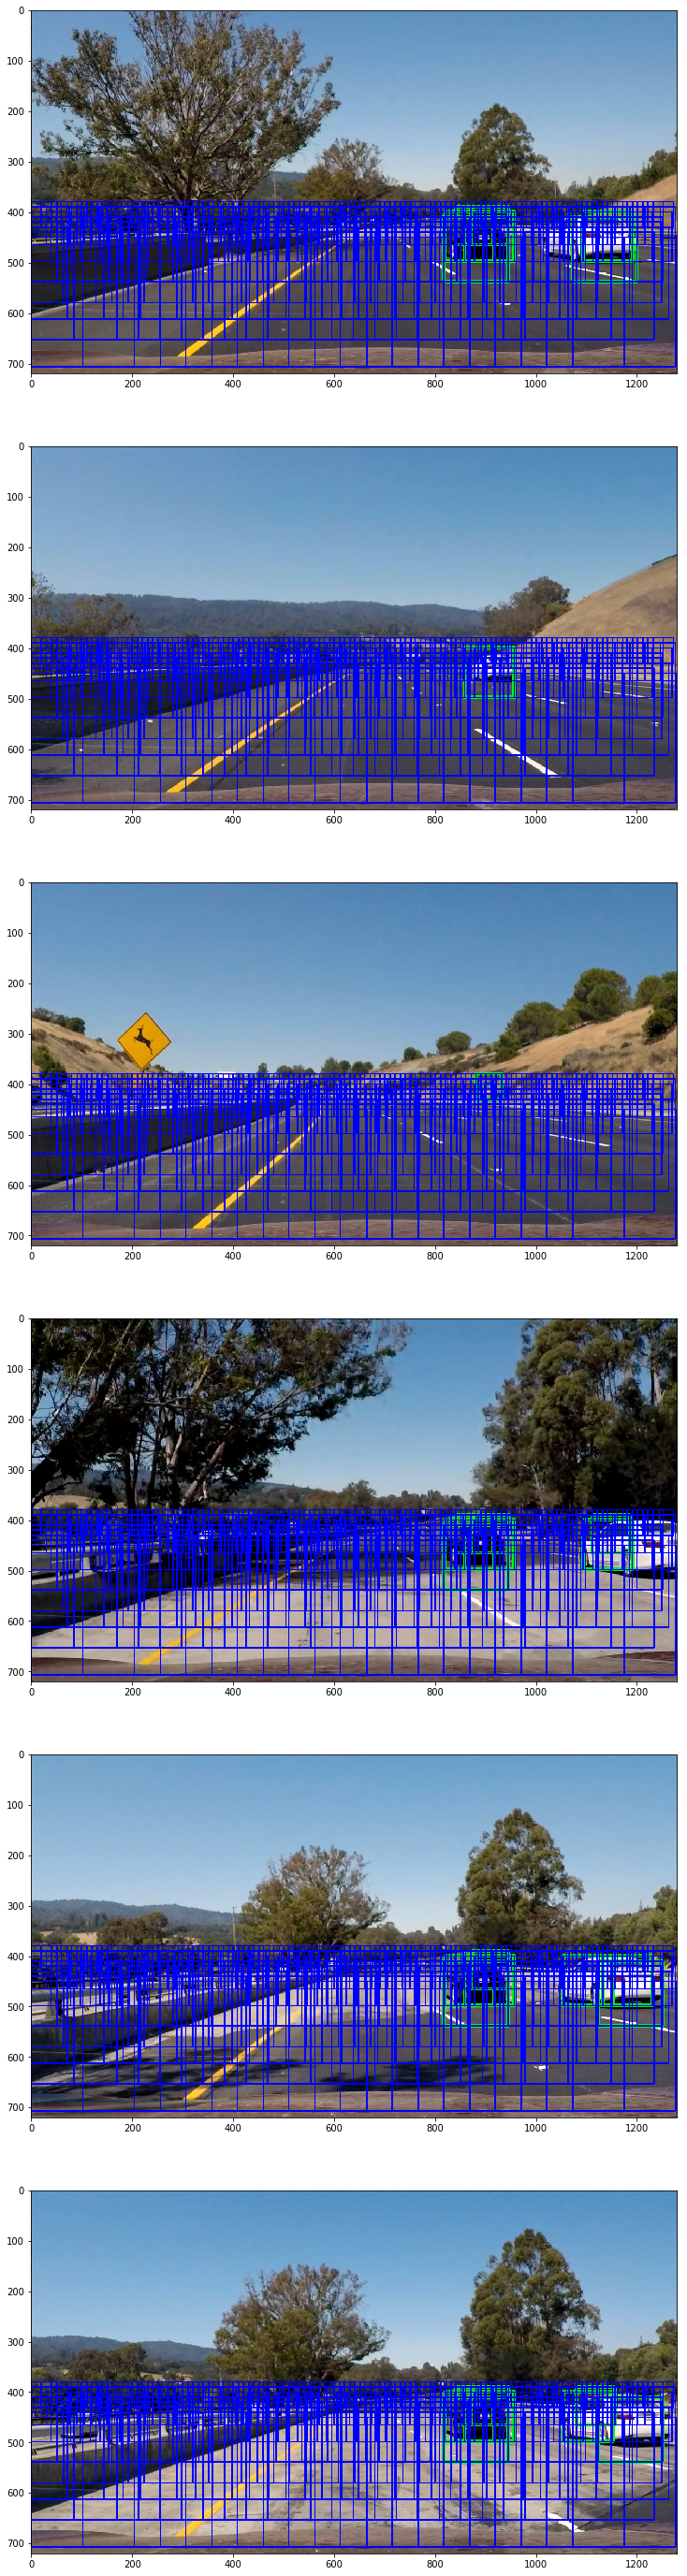

In [90]:
test_images = glob.glob('test_images/*.jpg')
plt.figure(1, figsize=(50,50))

plot_num = len(test_images)
it = 1
# parameter for find_cars
ystart = 400
ystop = 720
scale = 3
for file in test_images:
    # Read in each one by one
    image = mpimg.imread(file)
    draw_image  = np.copy(image)  
    image = image.astype(np.float32)/255
    (window_img, windows) = vehicle_detection(image, draw_image)
    #               find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #(window_img, windows)  =  multi_scale_hog_sub_sample_find_car(image, draw_image )
    #window_img = find_cars(image, draw_image, ystart, ystop, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    
    plt.subplot(plot_num,1,it)
    plt.imshow(window_img)
    it+=1
    
    
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
 

#window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    
# window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

plt.show()

In [61]:
from moviepy.editor import VideoFileClip

# load 
#white_output = 'test_video_out.mp4'
#clip1 = VideoFileClip("test_video.mp4")

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

In [ ]:
detector = Detector()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


Nr. bbox total 0
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:01<26:46,  1.28s/it]

Nr. bbox total 0






  0%|          | 2/1261 [00:02<26:43,  1.27s/it]

Nr. bbox total 0






  0%|          | 3/1261 [00:03<26:43,  1.27s/it]

Nr. bbox total 0






  0%|          | 4/1261 [00:05<26:43,  1.28s/it]

Nr. bbox total 0






  0%|          | 5/1261 [00:06<26:32,  1.27s/it]

Nr. bbox total 0






  0%|          | 6/1261 [00:07<26:23,  1.26s/it]

Nr. bbox total 0






  1%|          | 7/1261 [00:08<26:19,  1.26s/it]

Nr. bbox total 0






  1%|          | 8/1261 [00:10<26:17,  1.26s/it]

Nr. bbox total 0






  1%|          | 9/1261 [00:11<26:19,  1.26s/it]

Nr. bbox total 1






  1%|          | 10/1261 [00:12<26:15,  1.26s/it]

Nr. bbox total 1






  1%|          | 11/1261 [00:13<26:10,  1.26s/it]

Nr. bbox total 1






  1%|          | 12/1261 [00:15<26:18,  1.26s/it]

Nr. bbox total 1






  1%|          | 13/1261 [00:16<26:17,  1.26s/it]

Nr. bbox total 1






  1%|          | 14/1261 [00:17<26:22,  1.27s/it]

Nr. bbox total 1






  1%|          | 15/1261 [00:18<26:18,  1.27s/it]

Nr. bbox total 0






  1%|▏         | 16/1261 [00:20<26:20,  1.27s/it]

Nr. bbox total 0






  1%|▏         | 17/1261 [00:21<26:13,  1.26s/it]

Nr. bbox total 0






  1%|▏         | 18/1261 [00:22<26:09,  1.26s/it]

Nr. bbox total 0






  2%|▏         | 19/1261 [00:24<26:01,  1.26s/it]

Nr. bbox total 0






  2%|▏         | 20/1261 [00:25<25:56,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 21/1261 [00:26<25:51,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 22/1261 [00:27<25:53,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 23/1261 [00:28<25:46,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 24/1261 [00:30<25:43,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 25/1261 [00:31<25:39,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 26/1261 [00:32<25:38,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 27/1261 [00:33<25:37,  1.25s/it]

Nr. bbox total 0






  2%|▏         | 28/1261 [00:35<26:07,  1.27s/it]

Nr. bbox total 0






  2%|▏         | 29/1261 [00:36<25:59,  1.27s/it]

Nr. bbox total 0






  2%|▏         | 30/1261 [00:37<26:07,  1.27s/it]

Nr. bbox total 0






  2%|▏         | 31/1261 [00:39<27:49,  1.36s/it]

Nr. bbox total 0






  3%|▎         | 32/1261 [00:40<27:58,  1.37s/it]

Nr. bbox total 0






  3%|▎         | 33/1261 [00:42<27:34,  1.35s/it]

Nr. bbox total 0






  3%|▎         | 34/1261 [00:43<26:56,  1.32s/it]

Nr. bbox total 0






  3%|▎         | 35/1261 [00:44<26:39,  1.30s/it]

Nr. bbox total 0






  3%|▎         | 36/1261 [00:45<26:38,  1.31s/it]

Nr. bbox total 0






  3%|▎         | 37/1261 [00:47<28:11,  1.38s/it]

Nr. bbox total 0






  3%|▎         | 38/1261 [00:48<28:10,  1.38s/it]

Nr. bbox total 1






  3%|▎         | 39/1261 [00:50<27:44,  1.36s/it]

Nr. bbox total 1






  3%|▎         | 40/1261 [00:51<28:05,  1.38s/it]

Nr. bbox total 1






  3%|▎         | 41/1261 [00:52<27:19,  1.34s/it]

Nr. bbox total 1






  3%|▎         | 42/1261 [00:54<26:42,  1.31s/it]

Nr. bbox total 1






  3%|▎         | 43/1261 [00:55<26:22,  1.30s/it]

Nr. bbox total 1






  3%|▎         | 44/1261 [00:56<26:04,  1.29s/it]

Nr. bbox total 1






  4%|▎         | 45/1261 [00:57<25:52,  1.28s/it]

Nr. bbox total 1






  4%|▎         | 46/1261 [00:59<25:43,  1.27s/it]

Nr. bbox total 1






  4%|▎         | 47/1261 [01:00<25:38,  1.27s/it]

Nr. bbox total 2






  4%|▍         | 48/1261 [01:01<25:52,  1.28s/it]

Nr. bbox total 2






  4%|▍         | 49/1261 [01:03<26:31,  1.31s/it]

Nr. bbox total 2






  4%|▍         | 50/1261 [01:04<26:58,  1.34s/it]

Nr. bbox total 1






  4%|▍         | 51/1261 [01:05<27:17,  1.35s/it]

Nr. bbox total 1






  4%|▍         | 52/1261 [01:07<27:33,  1.37s/it]

Nr. bbox total 1






  4%|▍         | 53/1261 [01:09<29:45,  1.48s/it]

Nr. bbox total 0






  4%|▍         | 54/1261 [01:11<37:06,  1.84s/it]

Nr. bbox total 0






  4%|▍         | 55/1261 [01:13<38:13,  1.90s/it]

Nr. bbox total 0






  4%|▍         | 56/1261 [01:15<36:08,  1.80s/it]

Nr. bbox total 1






  5%|▍         | 57/1261 [01:17<36:58,  1.84s/it]

Nr. bbox total 1






  5%|▍         | 58/1261 [01:19<41:59,  2.09s/it]

Nr. bbox total 1






  5%|▍         | 59/1261 [01:21<40:07,  2.00s/it]

Nr. bbox total 1






  5%|▍         | 60/1261 [01:23<37:23,  1.87s/it]

Nr. bbox total 1






  5%|▍         | 61/1261 [01:25<37:34,  1.88s/it]

Nr. bbox total 1






  5%|▍         | 62/1261 [01:27<42:18,  2.12s/it]

Nr. bbox total 0






  5%|▍         | 63/1261 [01:29<41:31,  2.08s/it]

Nr. bbox total 0






  5%|▌         | 64/1261 [01:31<39:59,  2.00s/it]

Nr. bbox total 0






  5%|▌         | 65/1261 [01:33<37:41,  1.89s/it]

Nr. bbox total 0






  5%|▌         | 66/1261 [01:34<34:40,  1.74s/it]

Nr. bbox total 0






  5%|▌         | 67/1261 [01:36<32:34,  1.64s/it]

Nr. bbox total 0






  5%|▌         | 68/1261 [01:37<31:53,  1.60s/it]

Nr. bbox total 0






  5%|▌         | 69/1261 [01:39<31:32,  1.59s/it]

Nr. bbox total 0






  6%|▌         | 70/1261 [01:40<31:10,  1.57s/it]

Nr. bbox total 0






  6%|▌         | 71/1261 [01:42<30:03,  1.52s/it]

Nr. bbox total 0






  6%|▌         | 72/1261 [01:43<29:17,  1.48s/it]

Nr. bbox total 0






  6%|▌         | 73/1261 [01:44<29:07,  1.47s/it]

Nr. bbox total 0






  6%|▌         | 74/1261 [01:46<29:35,  1.50s/it]

Nr. bbox total 0






  6%|▌         | 75/1261 [01:48<29:57,  1.52s/it]

Nr. bbox total 0






  6%|▌         | 76/1261 [01:49<29:34,  1.50s/it]

Nr. bbox total 0






  6%|▌         | 77/1261 [01:50<29:02,  1.47s/it]

Nr. bbox total 0






  6%|▌         | 78/1261 [01:52<28:35,  1.45s/it]

Nr. bbox total 0






  6%|▋         | 79/1261 [01:53<27:30,  1.40s/it]

Nr. bbox total 0






  6%|▋         | 80/1261 [01:54<26:45,  1.36s/it]

Nr. bbox total 0






  6%|▋         | 81/1261 [01:56<26:10,  1.33s/it]

Nr. bbox total 0






  7%|▋         | 82/1261 [01:57<25:43,  1.31s/it]

Nr. bbox total 0






  7%|▋         | 83/1261 [01:58<25:30,  1.30s/it]

Nr. bbox total 0






  7%|▋         | 84/1261 [01:59<25:16,  1.29s/it]

Nr. bbox total 0






  7%|▋         | 85/1261 [02:01<25:09,  1.28s/it]

Nr. bbox total 0






  7%|▋         | 86/1261 [02:02<25:08,  1.28s/it]

Nr. bbox total 0






  7%|▋         | 87/1261 [02:03<25:02,  1.28s/it]

Nr. bbox total 0






  7%|▋         | 88/1261 [02:05<25:22,  1.30s/it]

Nr. bbox total 0






  7%|▋         | 89/1261 [02:06<25:56,  1.33s/it]

Nr. bbox total 0






  7%|▋         | 90/1261 [02:07<26:21,  1.35s/it]

Nr. bbox total 0






  7%|▋         | 91/1261 [02:10<31:33,  1.62s/it]

Nr. bbox total 0






  7%|▋         | 92/1261 [02:12<37:05,  1.90s/it]

Nr. bbox total 0






  7%|▋         | 93/1261 [02:14<35:05,  1.80s/it]

Nr. bbox total 0






  7%|▋         | 94/1261 [02:15<33:36,  1.73s/it]

Nr. bbox total 0






  8%|▊         | 95/1261 [02:18<36:46,  1.89s/it]

Nr. bbox total 0






  8%|▊         | 96/1261 [02:20<40:42,  2.10s/it]

Nr. bbox total 0






  8%|▊         | 97/1261 [02:22<37:28,  1.93s/it]

Nr. bbox total 0






  8%|▊         | 98/1261 [02:23<35:13,  1.82s/it]

Nr. bbox total 0






  8%|▊         | 99/1261 [02:26<37:59,  1.96s/it]

Nr. bbox total 0






  8%|▊         | 100/1261 [02:28<41:39,  2.15s/it]

Nr. bbox total 0






  8%|▊         | 101/1261 [02:30<38:08,  1.97s/it]

Nr. bbox total 0






  8%|▊         | 102/1261 [02:31<35:40,  1.85s/it]

Nr. bbox total 0






  8%|▊         | 103/1261 [02:33<33:28,  1.73s/it]

Nr. bbox total 0






  8%|▊         | 104/1261 [02:34<31:30,  1.63s/it]

Nr. bbox total 0






  8%|▊         | 105/1261 [02:36<30:10,  1.57s/it]

Nr. bbox total 0






  8%|▊         | 106/1261 [02:37<28:35,  1.49s/it]

Nr. bbox total 0






  8%|▊         | 107/1261 [02:38<27:24,  1.42s/it]

Nr. bbox total 1






  9%|▊         | 108/1261 [02:39<26:25,  1.38s/it]

Nr. bbox total 1






  9%|▊         | 109/1261 [02:41<26:13,  1.37s/it]

Nr. bbox total 1






  9%|▊         | 110/1261 [02:42<26:21,  1.37s/it]

Nr. bbox total 1






  9%|▉         | 111/1261 [02:44<26:27,  1.38s/it]

Nr. bbox total 1






  9%|▉         | 112/1261 [02:45<25:55,  1.35s/it]

Nr. bbox total 2






  9%|▉         | 113/1261 [02:46<25:24,  1.33s/it]

Nr. bbox total 1






  9%|▉         | 114/1261 [02:47<25:15,  1.32s/it]

Nr. bbox total 1






  9%|▉         | 115/1261 [02:49<25:39,  1.34s/it]

Nr. bbox total 1






  9%|▉         | 116/1261 [02:50<26:00,  1.36s/it]

Nr. bbox total 1






  9%|▉         | 117/1261 [02:52<26:13,  1.38s/it]

Nr. bbox total 1






  9%|▉         | 118/1261 [02:54<32:43,  1.72s/it]

Nr. bbox total 1






  9%|▉         | 119/1261 [02:57<36:44,  1.93s/it]

Nr. bbox total 1






 10%|▉         | 120/1261 [02:58<34:37,  1.82s/it]

Nr. bbox total 2






 10%|▉         | 121/1261 [03:00<33:04,  1.74s/it]

Nr. bbox total 2






 10%|▉         | 122/1261 [03:02<38:08,  2.01s/it]

Nr. bbox total 2






 10%|▉         | 123/1261 [03:05<40:18,  2.13s/it]

Nr. bbox total 2






 10%|▉         | 124/1261 [03:06<37:05,  1.96s/it]

Nr. bbox total 1






 10%|▉         | 125/1261 [03:08<34:45,  1.84s/it]

Nr. bbox total 1






 10%|▉         | 126/1261 [03:10<39:36,  2.09s/it]

Nr. bbox total 0






 10%|█         | 127/1261 [03:13<40:37,  2.15s/it]

Nr. bbox total 0






 10%|█         | 128/1261 [03:15<38:28,  2.04s/it]

Nr. bbox total 1






 10%|█         | 129/1261 [03:16<35:43,  1.89s/it]

Nr. bbox total 1






 10%|█         | 130/1261 [03:18<33:47,  1.79s/it]

Nr. bbox total 1






 10%|█         | 131/1261 [03:19<32:24,  1.72s/it]

Nr. bbox total 1






 10%|█         | 132/1261 [03:22<36:48,  1.96s/it]

Nr. bbox total 1






 11%|█         | 133/1261 [03:24<41:09,  2.19s/it]

Nr. bbox total 2






 11%|█         | 134/1261 [03:26<36:04,  1.92s/it]

Nr. bbox total 1






 11%|█         | 135/1261 [03:27<32:30,  1.73s/it]

Nr. bbox total 1






 11%|█         | 136/1261 [03:28<29:53,  1.59s/it]

Nr. bbox total 3






 11%|█         | 137/1261 [03:30<28:00,  1.49s/it]

Nr. bbox total 4






 11%|█         | 138/1261 [03:31<26:42,  1.43s/it]

Nr. bbox total 6






 11%|█         | 139/1261 [03:32<25:49,  1.38s/it]

Nr. bbox total 6






 11%|█         | 140/1261 [03:33<25:13,  1.35s/it]

Nr. bbox total 6






 11%|█         | 141/1261 [03:35<24:48,  1.33s/it]

Nr. bbox total 6






 11%|█▏        | 142/1261 [03:36<24:26,  1.31s/it]

Nr. bbox total 4






 11%|█▏        | 143/1261 [03:37<24:23,  1.31s/it]

Nr. bbox total 3






 11%|█▏        | 144/1261 [03:39<24:11,  1.30s/it]

Nr. bbox total 1






 11%|█▏        | 145/1261 [03:40<24:19,  1.31s/it]

Nr. bbox total 0






 12%|█▏        | 146/1261 [03:41<24:30,  1.32s/it]

Nr. bbox total 0






 12%|█▏        | 147/1261 [03:43<24:33,  1.32s/it]

Nr. bbox total 0






 12%|█▏        | 148/1261 [03:44<24:23,  1.31s/it]

Nr. bbox total 0






 12%|█▏        | 149/1261 [03:45<24:19,  1.31s/it]

Nr. bbox total 0






 12%|█▏        | 150/1261 [03:46<24:15,  1.31s/it]

Nr. bbox total 0






 12%|█▏        | 151/1261 [03:48<24:06,  1.30s/it]

Nr. bbox total 0






 12%|█▏        | 152/1261 [03:49<24:33,  1.33s/it]

Nr. bbox total 0






 12%|█▏        | 153/1261 [03:50<24:35,  1.33s/it]

Nr. bbox total 0






 12%|█▏        | 154/1261 [03:52<24:29,  1.33s/it]

Nr. bbox total 0






 12%|█▏        | 155/1261 [03:53<24:15,  1.32s/it]

Nr. bbox total 0






 12%|█▏        | 156/1261 [03:54<24:08,  1.31s/it]

Nr. bbox total 0






 12%|█▏        | 157/1261 [03:56<23:57,  1.30s/it]

Nr. bbox total 0






 13%|█▎        | 158/1261 [03:57<24:05,  1.31s/it]

Nr. bbox total 0






 13%|█▎        | 159/1261 [03:58<24:40,  1.34s/it]

Nr. bbox total 0






 13%|█▎        | 160/1261 [04:00<24:20,  1.33s/it]

Nr. bbox total 1






 13%|█▎        | 161/1261 [04:01<24:21,  1.33s/it]

Nr. bbox total 2






 13%|█▎        | 162/1261 [04:02<24:47,  1.35s/it]

Nr. bbox total 4






 13%|█▎        | 163/1261 [04:04<24:59,  1.37s/it]

Nr. bbox total 5






 13%|█▎        | 164/1261 [04:05<25:10,  1.38s/it]

Nr. bbox total 7






 13%|█▎        | 165/1261 [04:08<30:17,  1.66s/it]

Nr. bbox total 8






 13%|█▎        | 166/1261 [04:10<35:56,  1.97s/it]

Nr. bbox total 9






 13%|█▎        | 167/1261 [04:13<39:53,  2.19s/it]

Nr. bbox total 9






 13%|█▎        | 168/1261 [04:15<41:14,  2.26s/it]

Nr. bbox total 8






 13%|█▎        | 169/1261 [04:17<36:39,  2.01s/it]

Nr. bbox total 9






 13%|█▎        | 170/1261 [04:18<32:32,  1.79s/it]

Nr. bbox total 8






 14%|█▎        | 171/1261 [04:19<29:45,  1.64s/it]

Nr. bbox total 8






 14%|█▎        | 172/1261 [04:21<27:47,  1.53s/it]

Nr. bbox total 8






 14%|█▎        | 173/1261 [04:22<26:43,  1.47s/it]

Nr. bbox total 10






 14%|█▍        | 174/1261 [04:23<25:40,  1.42s/it]

Nr. bbox total 12






 14%|█▍        | 175/1261 [04:25<24:57,  1.38s/it]

Nr. bbox total 12






 14%|█▍        | 176/1261 [04:26<24:30,  1.36s/it]

Nr. bbox total 13






 14%|█▍        | 177/1261 [04:27<24:09,  1.34s/it]

Nr. bbox total 13






 14%|█▍        | 178/1261 [04:28<23:56,  1.33s/it]

Nr. bbox total 12






 14%|█▍        | 179/1261 [04:30<23:45,  1.32s/it]

Nr. bbox total 10






 14%|█▍        | 180/1261 [04:31<23:34,  1.31s/it]

Nr. bbox total 8






 14%|█▍        | 181/1261 [04:32<23:25,  1.30s/it]

Nr. bbox total 7






 14%|█▍        | 182/1261 [04:34<23:24,  1.30s/it]

Nr. bbox total 6






 15%|█▍        | 183/1261 [04:35<23:23,  1.30s/it]

Nr. bbox total 6






 15%|█▍        | 184/1261 [04:36<23:25,  1.30s/it]

Nr. bbox total 6






 15%|█▍        | 185/1261 [04:38<23:21,  1.30s/it]

Nr. bbox total 7






 15%|█▍        | 186/1261 [04:39<23:28,  1.31s/it]

Nr. bbox total 7






 15%|█▍        | 187/1261 [04:40<23:59,  1.34s/it]

Nr. bbox total 7






 15%|█▍        | 188/1261 [04:42<24:17,  1.36s/it]

Nr. bbox total 7






 15%|█▍        | 189/1261 [04:43<24:30,  1.37s/it]

Nr. bbox total 8






 15%|█▌        | 190/1261 [04:45<28:01,  1.57s/it]

Nr. bbox total 8






 15%|█▌        | 191/1261 [04:48<34:03,  1.91s/it]

Nr. bbox total 7






 15%|█▌        | 192/1261 [04:50<38:13,  2.15s/it]

Nr. bbox total 8






 15%|█▌        | 193/1261 [04:53<38:53,  2.18s/it]

Nr. bbox total 9






 15%|█▌        | 194/1261 [04:54<33:57,  1.91s/it]

Nr. bbox total 10






 15%|█▌        | 195/1261 [04:55<30:34,  1.72s/it]

Nr. bbox total 10






 16%|█▌        | 196/1261 [04:57<28:07,  1.58s/it]

Nr. bbox total 11






 16%|█▌        | 197/1261 [04:58<26:25,  1.49s/it]

Nr. bbox total 12






 16%|█▌        | 198/1261 [04:59<25:18,  1.43s/it]

Nr. bbox total 11






 16%|█▌        | 199/1261 [05:00<24:30,  1.39s/it]

Nr. bbox total 11






 16%|█▌        | 200/1261 [05:02<24:18,  1.37s/it]

Nr. bbox total 13






 16%|█▌        | 201/1261 [05:03<25:26,  1.44s/it]

Nr. bbox total 15






 16%|█▌        | 202/1261 [05:09<45:30,  2.58s/it]

Nr. bbox total 16






 16%|█▌        | 203/1261 [05:14<1:00:46,  3.45s/it]

Nr. bbox total 16






 16%|█▌        | 204/1261 [05:18<1:01:33,  3.49s/it]

Nr. bbox total 18






 16%|█▋        | 205/1261 [05:19<50:14,  2.85s/it]  

Nr. bbox total 19






 16%|█▋        | 206/1261 [05:20<42:27,  2.41s/it]

Nr. bbox total 18






 16%|█▋        | 207/1261 [05:22<36:31,  2.08s/it]

Nr. bbox total 16






 16%|█▋        | 208/1261 [05:23<32:28,  1.85s/it]

Nr. bbox total 15






 17%|█▋        | 209/1261 [05:24<29:42,  1.69s/it]

Nr. bbox total 15






 17%|█▋        | 210/1261 [05:26<27:44,  1.58s/it]

Nr. bbox total 15






 17%|█▋        | 211/1261 [05:27<26:21,  1.51s/it]

Nr. bbox total 14






 17%|█▋        | 212/1261 [05:28<25:29,  1.46s/it]

Nr. bbox total 15






 17%|█▋        | 213/1261 [05:30<24:48,  1.42s/it]

Nr. bbox total 16






 17%|█▋        | 214/1261 [05:31<23:59,  1.38s/it]

Nr. bbox total 16






 17%|█▋        | 215/1261 [05:32<23:23,  1.34s/it]

Nr. bbox total 15






 17%|█▋        | 216/1261 [05:34<22:58,  1.32s/it]

Nr. bbox total 13






 17%|█▋        | 217/1261 [05:35<22:40,  1.30s/it]

Nr. bbox total 11






 17%|█▋        | 218/1261 [05:36<22:32,  1.30s/it]

Nr. bbox total 7






 17%|█▋        | 219/1261 [05:37<22:20,  1.29s/it]

Nr. bbox total 4






 17%|█▋        | 220/1261 [05:39<22:10,  1.28s/it]

Nr. bbox total 2






 18%|█▊        | 221/1261 [05:40<22:55,  1.32s/it]

Nr. bbox total 1






 18%|█▊        | 222/1261 [05:41<23:14,  1.34s/it]

Nr. bbox total 1






 18%|█▊        | 223/1261 [05:43<22:54,  1.32s/it]

Nr. bbox total 2






 18%|█▊        | 224/1261 [05:44<22:37,  1.31s/it]

Nr. bbox total 3






 18%|█▊        | 225/1261 [05:45<22:28,  1.30s/it]

Nr. bbox total 4






 18%|█▊        | 226/1261 [05:47<22:23,  1.30s/it]

Nr. bbox total 5






 18%|█▊        | 227/1261 [05:48<22:29,  1.31s/it]

Nr. bbox total 6






 18%|█▊        | 228/1261 [05:49<22:44,  1.32s/it]

Nr. bbox total 6






 18%|█▊        | 229/1261 [05:51<22:40,  1.32s/it]

Nr. bbox total 8






 18%|█▊        | 230/1261 [05:52<22:38,  1.32s/it]

Nr. bbox total 11






 18%|█▊        | 231/1261 [05:53<22:37,  1.32s/it]

Nr. bbox total 15






 18%|█▊        | 232/1261 [05:54<22:32,  1.31s/it]

Nr. bbox total 20






 18%|█▊        | 233/1261 [05:56<22:29,  1.31s/it]

Nr. bbox total 25






 19%|█▊        | 234/1261 [05:57<22:44,  1.33s/it]

Nr. bbox total 29






 19%|█▊        | 235/1261 [05:59<23:00,  1.35s/it]

Nr. bbox total 32






 19%|█▊        | 236/1261 [06:00<22:50,  1.34s/it]

Nr. bbox total 35






 19%|█▉        | 237/1261 [06:01<22:46,  1.33s/it]

Nr. bbox total 34






 19%|█▉        | 238/1261 [06:02<22:44,  1.33s/it]

Nr. bbox total 32






 19%|█▉        | 239/1261 [06:04<22:38,  1.33s/it]

Nr. bbox total 30






 19%|█▉        | 240/1261 [06:05<22:37,  1.33s/it]

Nr. bbox total 28






 19%|█▉        | 241/1261 [06:06<22:30,  1.32s/it]

Nr. bbox total 24






 19%|█▉        | 242/1261 [06:08<22:33,  1.33s/it]

Nr. bbox total 19






 19%|█▉        | 243/1261 [06:09<22:45,  1.34s/it]

Nr. bbox total 17






 19%|█▉        | 244/1261 [06:10<22:42,  1.34s/it]

Nr. bbox total 16






 19%|█▉        | 245/1261 [06:12<23:01,  1.36s/it]

Nr. bbox total 15






 20%|█▉        | 246/1261 [06:13<23:11,  1.37s/it]

Nr. bbox total 16






 20%|█▉        | 247/1261 [06:15<23:19,  1.38s/it]

Nr. bbox total 17






 20%|█▉        | 248/1261 [06:17<28:11,  1.67s/it]

Nr. bbox total 18






 20%|█▉        | 249/1261 [06:20<33:25,  1.98s/it]

Nr. bbox total 19






 20%|█▉        | 250/1261 [06:23<37:24,  2.22s/it]

Nr. bbox total 20






 20%|█▉        | 251/1261 [06:25<36:26,  2.16s/it]

Nr. bbox total 19






 20%|█▉        | 252/1261 [06:26<32:13,  1.92s/it]

Nr. bbox total 18






 20%|██        | 253/1261 [06:27<28:59,  1.73s/it]

Nr. bbox total 18






 20%|██        | 254/1261 [06:29<26:58,  1.61s/it]

Nr. bbox total 17






 20%|██        | 255/1261 [06:30<25:18,  1.51s/it]

Nr. bbox total 17






 20%|██        | 256/1261 [06:31<24:05,  1.44s/it]

Nr. bbox total 16






 20%|██        | 257/1261 [06:32<23:17,  1.39s/it]

Nr. bbox total 16






 20%|██        | 258/1261 [06:34<22:41,  1.36s/it]

Nr. bbox total 15






 21%|██        | 259/1261 [06:35<23:07,  1.39s/it]

Nr. bbox total 15






 21%|██        | 260/1261 [06:36<22:35,  1.35s/it]

Nr. bbox total 17






 21%|██        | 261/1261 [06:38<22:13,  1.33s/it]

Nr. bbox total 18






 21%|██        | 262/1261 [06:39<22:25,  1.35s/it]

Nr. bbox total 19






 21%|██        | 263/1261 [06:40<22:02,  1.33s/it]

Nr. bbox total 20






 21%|██        | 264/1261 [06:42<21:43,  1.31s/it]

Nr. bbox total 21






 21%|██        | 265/1261 [06:43<22:14,  1.34s/it]

Nr. bbox total 23






 21%|██        | 266/1261 [06:44<21:56,  1.32s/it]

Nr. bbox total 22






 21%|██        | 267/1261 [06:46<21:42,  1.31s/it]

Nr. bbox total 21






 21%|██▏       | 268/1261 [06:47<21:31,  1.30s/it]

Nr. bbox total 21






 21%|██▏       | 269/1261 [06:48<21:20,  1.29s/it]

Nr. bbox total 21






 21%|██▏       | 270/1261 [06:49<21:45,  1.32s/it]

Nr. bbox total 21






 21%|██▏       | 271/1261 [06:51<22:08,  1.34s/it]

Nr. bbox total 19






 22%|██▏       | 272/1261 [06:52<22:25,  1.36s/it]

Nr. bbox total 19






 22%|██▏       | 273/1261 [06:54<22:03,  1.34s/it]

Nr. bbox total 19






 22%|██▏       | 274/1261 [06:55<22:32,  1.37s/it]

Nr. bbox total 18






 22%|██▏       | 275/1261 [06:56<22:04,  1.34s/it]

Nr. bbox total 18






 22%|██▏       | 276/1261 [06:58<22:16,  1.36s/it]

Nr. bbox total 19






 22%|██▏       | 277/1261 [06:59<22:29,  1.37s/it]

Nr. bbox total 20






 22%|██▏       | 278/1261 [07:00<22:40,  1.38s/it]

Nr. bbox total 21






 22%|██▏       | 279/1261 [07:03<28:59,  1.77s/it]

Nr. bbox total 22






 22%|██▏       | 280/1261 [07:05<31:34,  1.93s/it]

Nr. bbox total 24






 22%|██▏       | 281/1261 [07:07<29:46,  1.82s/it]

Nr. bbox total 26






 22%|██▏       | 282/1261 [07:09<28:43,  1.76s/it]

Nr. bbox total 26






 22%|██▏       | 283/1261 [07:11<33:20,  2.05s/it]

Nr. bbox total 24






 23%|██▎       | 284/1261 [07:14<34:17,  2.11s/it]

Nr. bbox total 22






 23%|██▎       | 285/1261 [07:15<31:41,  1.95s/it]

Nr. bbox total 21






 23%|██▎       | 286/1261 [07:17<30:34,  1.88s/it]

Nr. bbox total 20






 23%|██▎       | 287/1261 [07:20<34:40,  2.14s/it]

Nr. bbox total 19






 23%|██▎       | 288/1261 [07:22<34:41,  2.14s/it]

Nr. bbox total 20






 23%|██▎       | 289/1261 [07:24<32:54,  2.03s/it]

Nr. bbox total 20






 23%|██▎       | 290/1261 [07:25<30:38,  1.89s/it]

Nr. bbox total 22






 23%|██▎       | 291/1261 [07:27<29:02,  1.80s/it]

Nr. bbox total 21






 23%|██▎       | 292/1261 [07:28<27:54,  1.73s/it]

Nr. bbox total 20






 23%|██▎       | 293/1261 [07:31<33:21,  2.07s/it]

Nr. bbox total 19






 23%|██▎       | 294/1261 [07:34<38:43,  2.40s/it]

Nr. bbox total 16






 23%|██▎       | 295/1261 [07:37<39:37,  2.46s/it]

Nr. bbox total 17






 23%|██▎       | 296/1261 [07:38<34:06,  2.12s/it]

Nr. bbox total 17






 24%|██▎       | 297/1261 [07:40<30:05,  1.87s/it]

Nr. bbox total 17






 24%|██▎       | 298/1261 [07:41<27:26,  1.71s/it]

Nr. bbox total 16






 24%|██▎       | 299/1261 [07:42<25:34,  1.59s/it]

Nr. bbox total 16






 24%|██▍       | 300/1261 [07:44<24:14,  1.51s/it]

Nr. bbox total 15






 24%|██▍       | 301/1261 [07:45<23:24,  1.46s/it]

Nr. bbox total 13






 24%|██▍       | 302/1261 [07:46<22:51,  1.43s/it]

Nr. bbox total 11






 24%|██▍       | 303/1261 [07:48<22:24,  1.40s/it]

Nr. bbox total 11






 24%|██▍       | 304/1261 [07:49<22:45,  1.43s/it]

Nr. bbox total 11






 24%|██▍       | 305/1261 [07:50<22:35,  1.42s/it]

Nr. bbox total 12






 24%|██▍       | 306/1261 [07:52<22:17,  1.40s/it]

Nr. bbox total 12






 24%|██▍       | 307/1261 [07:53<22:05,  1.39s/it]

Nr. bbox total 14






 24%|██▍       | 308/1261 [07:55<21:54,  1.38s/it]

Nr. bbox total 14






 25%|██▍       | 309/1261 [07:56<21:47,  1.37s/it]

Nr. bbox total 15






 25%|██▍       | 310/1261 [07:57<21:47,  1.38s/it]

Nr. bbox total 16






 25%|██▍       | 311/1261 [07:59<21:47,  1.38s/it]

Nr. bbox total 14






 25%|██▍       | 312/1261 [08:00<21:45,  1.38s/it]

Nr. bbox total 15






 25%|██▍       | 313/1261 [08:02<22:34,  1.43s/it]

Nr. bbox total 14






 25%|██▍       | 314/1261 [08:03<22:27,  1.42s/it]

Nr. bbox total 14






 25%|██▍       | 315/1261 [08:04<22:22,  1.42s/it]

Nr. bbox total 14






 25%|██▌       | 316/1261 [08:06<25:15,  1.60s/it]

Nr. bbox total 13






 25%|██▌       | 317/1261 [08:09<30:31,  1.94s/it]

Nr. bbox total 14






 25%|██▌       | 318/1261 [08:12<33:13,  2.11s/it]

Nr. bbox total 15






 25%|██▌       | 319/1261 [08:14<31:56,  2.03s/it]

Nr. bbox total 16






 25%|██▌       | 320/1261 [08:15<28:22,  1.81s/it]

Nr. bbox total 16






 25%|██▌       | 321/1261 [08:16<25:52,  1.65s/it]

Nr. bbox total 15






 26%|██▌       | 322/1261 [08:17<24:11,  1.55s/it]

Nr. bbox total 15






 26%|██▌       | 323/1261 [08:19<22:54,  1.47s/it]

Nr. bbox total 14






 26%|██▌       | 324/1261 [08:20<22:08,  1.42s/it]

Nr. bbox total 14






 26%|██▌       | 325/1261 [08:21<21:32,  1.38s/it]

Nr. bbox total 12






 26%|██▌       | 326/1261 [08:23<21:03,  1.35s/it]

Nr. bbox total 11






 26%|██▌       | 327/1261 [08:24<20:41,  1.33s/it]

Nr. bbox total 10






 26%|██▌       | 328/1261 [08:25<20:28,  1.32s/it]

Nr. bbox total 9






 26%|██▌       | 329/1261 [08:26<20:26,  1.32s/it]

Nr. bbox total 10






 26%|██▌       | 330/1261 [08:28<20:17,  1.31s/it]

Nr. bbox total 9






 26%|██▌       | 331/1261 [08:29<20:03,  1.29s/it]

Nr. bbox total 9






 26%|██▋       | 332/1261 [08:30<19:59,  1.29s/it]

Nr. bbox total 9






 26%|██▋       | 333/1261 [08:32<19:52,  1.28s/it]

Nr. bbox total 9






 26%|██▋       | 334/1261 [08:33<19:45,  1.28s/it]

Nr. bbox total 9






 27%|██▋       | 335/1261 [08:34<19:44,  1.28s/it]

Nr. bbox total 7






 27%|██▋       | 336/1261 [08:35<20:21,  1.32s/it]

Nr. bbox total 6






 27%|██▋       | 337/1261 [08:37<20:47,  1.35s/it]

Nr. bbox total 6






 27%|██▋       | 338/1261 [08:38<21:21,  1.39s/it]

Nr. bbox total 6






 27%|██▋       | 339/1261 [08:41<27:24,  1.78s/it]

Nr. bbox total 7






 27%|██▋       | 340/1261 [08:44<31:43,  2.07s/it]

Nr. bbox total 8






 27%|██▋       | 341/1261 [08:46<33:38,  2.19s/it]

Nr. bbox total 8






 27%|██▋       | 342/1261 [08:48<30:18,  1.98s/it]

Nr. bbox total 9






 27%|██▋       | 343/1261 [08:49<27:14,  1.78s/it]

Nr. bbox total 9






 27%|██▋       | 344/1261 [08:50<25:16,  1.65s/it]

Nr. bbox total 10






 27%|██▋       | 345/1261 [08:52<23:53,  1.56s/it]

Nr. bbox total 11






 27%|██▋       | 346/1261 [08:53<22:34,  1.48s/it]

Nr. bbox total 12






 28%|██▊       | 347/1261 [08:54<21:39,  1.42s/it]

Nr. bbox total 14






 28%|██▊       | 348/1261 [08:56<21:02,  1.38s/it]

Nr. bbox total 15






 28%|██▊       | 349/1261 [08:57<20:33,  1.35s/it]

Nr. bbox total 17






 28%|██▊       | 350/1261 [08:58<20:17,  1.34s/it]

Nr. bbox total 18






 28%|██▊       | 351/1261 [09:00<20:01,  1.32s/it]

Nr. bbox total 17






 28%|██▊       | 352/1261 [09:01<20:01,  1.32s/it]

Nr. bbox total 16






 28%|██▊       | 353/1261 [09:02<20:01,  1.32s/it]

Nr. bbox total 15






 28%|██▊       | 354/1261 [09:04<19:56,  1.32s/it]

Nr. bbox total 14






 28%|██▊       | 355/1261 [09:05<19:51,  1.31s/it]

Nr. bbox total 13






 28%|██▊       | 356/1261 [09:06<19:46,  1.31s/it]

Nr. bbox total 12






 28%|██▊       | 357/1261 [09:07<19:48,  1.31s/it]

Nr. bbox total 12






 28%|██▊       | 358/1261 [09:09<19:45,  1.31s/it]

Nr. bbox total 13






 28%|██▊       | 359/1261 [09:10<19:43,  1.31s/it]

Nr. bbox total 14






 29%|██▊       | 360/1261 [09:11<19:36,  1.31s/it]

Nr. bbox total 14






 29%|██▊       | 361/1261 [09:13<19:26,  1.30s/it]

Nr. bbox total 14






 29%|██▊       | 362/1261 [09:14<19:44,  1.32s/it]

Nr. bbox total 14






 29%|██▉       | 363/1261 [09:15<20:06,  1.34s/it]

Nr. bbox total 15






 29%|██▉       | 364/1261 [09:17<20:22,  1.36s/it]

Nr. bbox total 13






 29%|██▉       | 365/1261 [09:18<20:32,  1.38s/it]

Nr. bbox total 11






 29%|██▉       | 366/1261 [09:21<24:49,  1.66s/it]

Nr. bbox total 9






 29%|██▉       | 367/1261 [09:23<29:24,  1.97s/it]

Nr. bbox total 7






 29%|██▉       | 368/1261 [09:26<32:36,  2.19s/it]

Nr. bbox total 6






 29%|██▉       | 369/1261 [09:29<34:51,  2.35s/it]

Nr. bbox total 4






 29%|██▉       | 370/1261 [09:31<36:23,  2.45s/it]

Nr. bbox total 5






 29%|██▉       | 371/1261 [09:33<32:39,  2.20s/it]

Nr. bbox total 6






 30%|██▉       | 372/1261 [09:34<28:32,  1.93s/it]

Nr. bbox total 9






 30%|██▉       | 373/1261 [09:36<25:40,  1.73s/it]

Nr. bbox total 12






 30%|██▉       | 374/1261 [09:37<23:36,  1.60s/it]

Nr. bbox total 14






 30%|██▉       | 375/1261 [09:38<22:13,  1.51s/it]

Nr. bbox total 16






 30%|██▉       | 376/1261 [09:39<21:16,  1.44s/it]

Nr. bbox total 16






 30%|██▉       | 377/1261 [09:41<20:43,  1.41s/it]

Nr. bbox total 16






 30%|██▉       | 378/1261 [09:42<20:09,  1.37s/it]

Nr. bbox total 15






 30%|███       | 379/1261 [09:43<19:51,  1.35s/it]

Nr. bbox total 14






 30%|███       | 380/1261 [09:45<19:40,  1.34s/it]

Nr. bbox total 14






 30%|███       | 381/1261 [09:46<19:24,  1.32s/it]

Nr. bbox total 13






 30%|███       | 382/1261 [09:47<19:19,  1.32s/it]

Nr. bbox total 14






 30%|███       | 383/1261 [09:49<19:09,  1.31s/it]

Nr. bbox total 14






 30%|███       | 384/1261 [09:50<19:58,  1.37s/it]

Nr. bbox total 16






 31%|███       | 385/1261 [09:51<19:37,  1.34s/it]

Nr. bbox total 18






 31%|███       | 386/1261 [09:53<19:26,  1.33s/it]

Nr. bbox total 19






 31%|███       | 387/1261 [09:54<19:29,  1.34s/it]

Nr. bbox total 21






 31%|███       | 388/1261 [09:55<19:48,  1.36s/it]

Nr. bbox total 21






 31%|███       | 389/1261 [09:57<20:00,  1.38s/it]

Nr. bbox total 23






 31%|███       | 390/1261 [09:58<20:09,  1.39s/it]

Nr. bbox total 23






 31%|███       | 391/1261 [10:01<25:19,  1.75s/it]

Nr. bbox total 21






 31%|███       | 392/1261 [10:03<29:28,  2.03s/it]

Nr. bbox total 20






 31%|███       | 393/1261 [10:06<29:55,  2.07s/it]

Nr. bbox total 19






 31%|███       | 394/1261 [10:07<26:30,  1.83s/it]

Nr. bbox total 19






 31%|███▏      | 395/1261 [10:08<24:04,  1.67s/it]

Nr. bbox total 17






 31%|███▏      | 396/1261 [10:10<22:25,  1.56s/it]

Nr. bbox total 15






 31%|███▏      | 397/1261 [10:11<21:14,  1.48s/it]

Nr. bbox total 15






 32%|███▏      | 398/1261 [10:12<20:21,  1.42s/it]

Nr. bbox total 14






 32%|███▏      | 399/1261 [10:13<19:51,  1.38s/it]

Nr. bbox total 14






 32%|███▏      | 400/1261 [10:15<19:28,  1.36s/it]

Nr. bbox total 13






 32%|███▏      | 401/1261 [10:16<19:10,  1.34s/it]

Nr. bbox total 13






 32%|███▏      | 402/1261 [10:17<19:08,  1.34s/it]

Nr. bbox total 12






 32%|███▏      | 403/1261 [10:19<18:56,  1.32s/it]

Nr. bbox total 11






 32%|███▏      | 404/1261 [10:20<18:50,  1.32s/it]

Nr. bbox total 11






 32%|███▏      | 405/1261 [10:21<18:54,  1.33s/it]

Nr. bbox total 11






 32%|███▏      | 406/1261 [10:23<18:49,  1.32s/it]

Nr. bbox total 11






 32%|███▏      | 407/1261 [10:24<18:44,  1.32s/it]

Nr. bbox total 11






 32%|███▏      | 408/1261 [10:25<18:43,  1.32s/it]

Nr. bbox total 12






 32%|███▏      | 409/1261 [10:26<18:39,  1.31s/it]

Nr. bbox total 12






 33%|███▎      | 410/1261 [10:28<18:47,  1.32s/it]

Nr. bbox total 11






 33%|███▎      | 411/1261 [10:29<19:08,  1.35s/it]

Nr. bbox total 11






 33%|███▎      | 412/1261 [10:31<19:20,  1.37s/it]

Nr. bbox total 12






 33%|███▎      | 413/1261 [10:32<19:28,  1.38s/it]

Nr. bbox total 13






 33%|███▎      | 414/1261 [10:35<24:03,  1.70s/it]

Nr. bbox total 14






 33%|███▎      | 415/1261 [10:37<28:19,  2.01s/it]

Nr. bbox total 14






 33%|███▎      | 416/1261 [10:40<31:15,  2.22s/it]

Nr. bbox total 15






 33%|███▎      | 417/1261 [10:42<31:11,  2.22s/it]

Nr. bbox total 13






 33%|███▎      | 418/1261 [10:44<29:35,  2.11s/it]

Nr. bbox total 10






 33%|███▎      | 419/1261 [10:45<26:21,  1.88s/it]

Nr. bbox total 8






 33%|███▎      | 420/1261 [10:47<23:48,  1.70s/it]

Nr. bbox total 6






 33%|███▎      | 421/1261 [10:48<22:00,  1.57s/it]

Nr. bbox total 7






 33%|███▎      | 422/1261 [10:49<20:46,  1.49s/it]

Nr. bbox total 6






 34%|███▎      | 423/1261 [10:50<19:57,  1.43s/it]

Nr. bbox total 7






 34%|███▎      | 424/1261 [10:52<19:16,  1.38s/it]

Nr. bbox total 10






 34%|███▎      | 425/1261 [10:53<18:51,  1.35s/it]

Nr. bbox total 11






 34%|███▍      | 426/1261 [10:54<18:31,  1.33s/it]

Nr. bbox total 13






 34%|███▍      | 427/1261 [10:56<18:17,  1.32s/it]

Nr. bbox total 13






 34%|███▍      | 428/1261 [10:57<18:05,  1.30s/it]

Nr. bbox total 15






 34%|███▍      | 429/1261 [10:58<18:13,  1.31s/it]

Nr. bbox total 16






 34%|███▍      | 430/1261 [11:00<18:03,  1.30s/it]

Nr. bbox total 17






 34%|███▍      | 431/1261 [11:01<18:02,  1.30s/it]

Nr. bbox total 18






 34%|███▍      | 432/1261 [11:02<17:59,  1.30s/it]

Nr. bbox total 19






 34%|███▍      | 433/1261 [11:03<17:54,  1.30s/it]

Nr. bbox total 20






 34%|███▍      | 434/1261 [11:05<17:47,  1.29s/it]

Nr. bbox total 20






 34%|███▍      | 435/1261 [11:06<17:42,  1.29s/it]

Nr. bbox total 21






 35%|███▍      | 436/1261 [11:07<17:41,  1.29s/it]

Nr. bbox total 21






 35%|███▍      | 437/1261 [11:08<17:35,  1.28s/it]

Nr. bbox total 20






 35%|███▍      | 438/1261 [11:10<17:35,  1.28s/it]

Nr. bbox total 20






 35%|███▍      | 439/1261 [11:11<17:39,  1.29s/it]

Nr. bbox total 21






 35%|███▍      | 440/1261 [11:12<17:39,  1.29s/it]

Nr. bbox total 22






 35%|███▍      | 441/1261 [11:14<17:34,  1.29s/it]

Nr. bbox total 22






 35%|███▌      | 442/1261 [11:15<17:32,  1.28s/it]

Nr. bbox total 20






 35%|███▌      | 443/1261 [11:16<17:34,  1.29s/it]

Nr. bbox total 21






 35%|███▌      | 444/1261 [11:18<17:30,  1.29s/it]

Nr. bbox total 19






 35%|███▌      | 445/1261 [11:19<17:25,  1.28s/it]

Nr. bbox total 19






 35%|███▌      | 446/1261 [11:20<17:26,  1.28s/it]

Nr. bbox total 17






 35%|███▌      | 447/1261 [11:21<17:23,  1.28s/it]

Nr. bbox total 15






 36%|███▌      | 448/1261 [11:23<17:20,  1.28s/it]

Nr. bbox total 15






 36%|███▌      | 449/1261 [11:24<17:18,  1.28s/it]

Nr. bbox total 14






 36%|███▌      | 450/1261 [11:25<17:22,  1.28s/it]

Nr. bbox total 15






 36%|███▌      | 451/1261 [11:26<17:17,  1.28s/it]

Nr. bbox total 12






 36%|███▌      | 452/1261 [11:28<17:12,  1.28s/it]

Nr. bbox total 11






 36%|███▌      | 453/1261 [11:29<17:12,  1.28s/it]

Nr. bbox total 10






 36%|███▌      | 454/1261 [11:30<17:11,  1.28s/it]

Nr. bbox total 9






 36%|███▌      | 455/1261 [11:32<17:10,  1.28s/it]

Nr. bbox total 8






 36%|███▌      | 456/1261 [11:33<17:12,  1.28s/it]

Nr. bbox total 6






 36%|███▌      | 457/1261 [11:34<17:11,  1.28s/it]

Nr. bbox total 6






 36%|███▋      | 458/1261 [11:35<17:17,  1.29s/it]

Nr. bbox total 6






 36%|███▋      | 459/1261 [11:37<17:11,  1.29s/it]

Nr. bbox total 7






 36%|███▋      | 460/1261 [11:38<17:09,  1.29s/it]

Nr. bbox total 8






 37%|███▋      | 461/1261 [11:39<17:06,  1.28s/it]

Nr. bbox total 8






 37%|███▋      | 462/1261 [11:41<17:03,  1.28s/it]

Nr. bbox total 8






 37%|███▋      | 463/1261 [11:42<16:59,  1.28s/it]

Nr. bbox total 9






 37%|███▋      | 464/1261 [11:43<17:02,  1.28s/it]

Nr. bbox total 10






 37%|███▋      | 465/1261 [11:44<17:05,  1.29s/it]

Nr. bbox total 10






 37%|███▋      | 466/1261 [11:46<17:02,  1.29s/it]

Nr. bbox total 10






 37%|███▋      | 467/1261 [11:47<17:28,  1.32s/it]

Nr. bbox total 11






 37%|███▋      | 468/1261 [11:48<17:15,  1.31s/it]

Nr. bbox total 12






 37%|███▋      | 469/1261 [11:50<17:56,  1.36s/it]

Nr. bbox total 12






 37%|███▋      | 470/1261 [11:51<17:41,  1.34s/it]

Nr. bbox total 12






 37%|███▋      | 471/1261 [11:53<17:35,  1.34s/it]

Nr. bbox total 12






 37%|███▋      | 472/1261 [11:54<17:21,  1.32s/it]

Nr. bbox total 12






 38%|███▊      | 473/1261 [11:55<17:59,  1.37s/it]

Nr. bbox total 12






 38%|███▊      | 474/1261 [11:57<18:08,  1.38s/it]

Nr. bbox total 12






 38%|███▊      | 475/1261 [11:58<18:17,  1.40s/it]

Nr. bbox total 13






 38%|███▊      | 476/1261 [12:00<21:00,  1.61s/it]

Nr. bbox total 13






 38%|███▊      | 477/1261 [12:03<25:20,  1.94s/it]

Nr. bbox total 14






 38%|███▊      | 478/1261 [12:06<28:19,  2.17s/it]

Nr. bbox total 14






 38%|███▊      | 479/1261 [12:08<30:24,  2.33s/it]

Nr. bbox total 14






 38%|███▊      | 480/1261 [12:11<31:50,  2.45s/it]

Nr. bbox total 16






 38%|███▊      | 481/1261 [12:14<32:49,  2.52s/it]

Nr. bbox total 15






 38%|███▊      | 482/1261 [12:16<33:29,  2.58s/it]

Nr. bbox total 15






 38%|███▊      | 483/1261 [12:19<33:59,  2.62s/it]

Nr. bbox total 14






 38%|███▊      | 484/1261 [12:22<34:19,  2.65s/it]

Nr. bbox total 14






 38%|███▊      | 485/1261 [12:25<34:36,  2.68s/it]

Nr. bbox total 14






 39%|███▊      | 486/1261 [12:27<34:49,  2.70s/it]

Nr. bbox total 12






 39%|███▊      | 487/1261 [12:30<33:46,  2.62s/it]

Nr. bbox total 12






 39%|███▊      | 488/1261 [12:31<28:37,  2.22s/it]

Nr. bbox total 12






 39%|███▉      | 489/1261 [12:32<25:13,  1.96s/it]

Nr. bbox total 12






 39%|███▉      | 490/1261 [12:34<22:41,  1.77s/it]

Nr. bbox total 13






 39%|███▉      | 491/1261 [12:35<21:04,  1.64s/it]

Nr. bbox total 13






 39%|███▉      | 492/1261 [12:37<20:03,  1.56s/it]

Nr. bbox total 13






 39%|███▉      | 493/1261 [12:38<19:05,  1.49s/it]

Nr. bbox total 13






 39%|███▉      | 494/1261 [12:39<18:35,  1.45s/it]

Nr. bbox total 13






 39%|███▉      | 495/1261 [12:41<18:20,  1.44s/it]

Nr. bbox total 13






 39%|███▉      | 496/1261 [12:42<17:55,  1.41s/it]

Nr. bbox total 12






 39%|███▉      | 497/1261 [12:43<17:46,  1.40s/it]

Nr. bbox total 12






 39%|███▉      | 498/1261 [12:45<17:18,  1.36s/it]

Nr. bbox total 12






 40%|███▉      | 499/1261 [12:46<16:57,  1.34s/it]

Nr. bbox total 13






 40%|███▉      | 500/1261 [12:47<16:44,  1.32s/it]

Nr. bbox total 14






 40%|███▉      | 501/1261 [12:48<16:36,  1.31s/it]

Nr. bbox total 14






 40%|███▉      | 502/1261 [12:50<16:27,  1.30s/it]

Nr. bbox total 14






 40%|███▉      | 503/1261 [12:51<16:30,  1.31s/it]

Nr. bbox total 14






 40%|███▉      | 504/1261 [12:52<16:37,  1.32s/it]

Nr. bbox total 13






 40%|████      | 505/1261 [12:54<17:00,  1.35s/it]

Nr. bbox total 11






 40%|████      | 506/1261 [12:55<17:13,  1.37s/it]

Nr. bbox total 9






 40%|████      | 507/1261 [12:57<20:12,  1.61s/it]

Nr. bbox total 9






 40%|████      | 508/1261 [13:00<24:43,  1.97s/it]

Nr. bbox total 8






 40%|████      | 509/1261 [13:03<27:48,  2.22s/it]

Nr. bbox total 7






 40%|████      | 510/1261 [13:05<26:26,  2.11s/it]

Nr. bbox total 7






 41%|████      | 511/1261 [13:06<23:19,  1.87s/it]

Nr. bbox total 8






 41%|████      | 512/1261 [13:07<21:15,  1.70s/it]

Nr. bbox total 8






 41%|████      | 513/1261 [13:09<19:40,  1.58s/it]

Nr. bbox total 7






 41%|████      | 514/1261 [13:10<18:32,  1.49s/it]

Nr. bbox total 7






 41%|████      | 515/1261 [13:11<17:51,  1.44s/it]

Nr. bbox total 7






 41%|████      | 516/1261 [13:13<17:14,  1.39s/it]

Nr. bbox total 7






 41%|████      | 517/1261 [13:14<16:46,  1.35s/it]

Nr. bbox total 6






 41%|████      | 518/1261 [13:15<16:32,  1.34s/it]

Nr. bbox total 6






 41%|████      | 519/1261 [13:16<16:20,  1.32s/it]

Nr. bbox total 6






 41%|████      | 520/1261 [13:18<16:12,  1.31s/it]

Nr. bbox total 6






 41%|████▏     | 521/1261 [13:19<16:08,  1.31s/it]

Nr. bbox total 6






 41%|████▏     | 522/1261 [13:20<16:11,  1.32s/it]

Nr. bbox total 7






 41%|████▏     | 523/1261 [13:22<16:10,  1.32s/it]

Nr. bbox total 8






 42%|████▏     | 524/1261 [13:23<16:09,  1.32s/it]

Nr. bbox total 9






 42%|████▏     | 525/1261 [13:24<16:07,  1.31s/it]

Nr. bbox total 9






 42%|████▏     | 526/1261 [13:26<16:07,  1.32s/it]

Nr. bbox total 10






 42%|████▏     | 527/1261 [13:27<16:09,  1.32s/it]

Nr. bbox total 10






 42%|████▏     | 528/1261 [13:28<16:07,  1.32s/it]

Nr. bbox total 10






 42%|████▏     | 529/1261 [13:30<16:03,  1.32s/it]

Nr. bbox total 9






 42%|████▏     | 530/1261 [13:31<15:59,  1.31s/it]

Nr. bbox total 8






 42%|████▏     | 531/1261 [13:32<16:16,  1.34s/it]

Nr. bbox total 9






 42%|████▏     | 532/1261 [13:34<16:30,  1.36s/it]

Nr. bbox total 9






 42%|████▏     | 533/1261 [13:35<16:40,  1.37s/it]

Nr. bbox total 10






 42%|████▏     | 534/1261 [13:37<17:22,  1.43s/it]

Nr. bbox total 9






 42%|████▏     | 535/1261 [13:39<21:56,  1.81s/it]

Nr. bbox total 9






 43%|████▎     | 536/1261 [13:42<25:13,  2.09s/it]

Nr. bbox total 10






 43%|████▎     | 537/1261 [13:45<27:03,  2.24s/it]

Nr. bbox total 10






 43%|████▎     | 538/1261 [13:46<23:46,  1.97s/it]

Nr. bbox total 10






 43%|████▎     | 539/1261 [13:47<21:13,  1.76s/it]

Nr. bbox total 9






 43%|████▎     | 540/1261 [13:49<19:28,  1.62s/it]

Nr. bbox total 9






 43%|████▎     | 541/1261 [13:50<18:23,  1.53s/it]

Nr. bbox total 10






 43%|████▎     | 542/1261 [13:51<17:26,  1.46s/it]

Nr. bbox total 9






 43%|████▎     | 543/1261 [13:53<16:49,  1.41s/it]

Nr. bbox total 8






 43%|████▎     | 544/1261 [13:54<16:22,  1.37s/it]

Nr. bbox total 7






 43%|████▎     | 545/1261 [13:55<16:06,  1.35s/it]

Nr. bbox total 7






 43%|████▎     | 546/1261 [13:56<15:48,  1.33s/it]

Nr. bbox total 7






 43%|████▎     | 547/1261 [13:58<15:31,  1.30s/it]

Nr. bbox total 6






 43%|████▎     | 548/1261 [13:59<15:28,  1.30s/it]

Nr. bbox total 6






 44%|████▎     | 549/1261 [14:00<15:29,  1.31s/it]

Nr. bbox total 6






 44%|████▎     | 550/1261 [14:02<15:19,  1.29s/it]

Nr. bbox total 5






 44%|████▎     | 551/1261 [14:03<15:21,  1.30s/it]

Nr. bbox total 5






 44%|████▍     | 552/1261 [14:04<15:16,  1.29s/it]

Nr. bbox total 4






 44%|████▍     | 553/1261 [14:05<15:10,  1.29s/it]

Nr. bbox total 4






 44%|████▍     | 554/1261 [14:07<15:13,  1.29s/it]

Nr. bbox total 4






 44%|████▍     | 555/1261 [14:08<15:07,  1.29s/it]

Nr. bbox total 5






 44%|████▍     | 556/1261 [14:09<15:07,  1.29s/it]

Nr. bbox total 7






 44%|████▍     | 557/1261 [14:11<15:05,  1.29s/it]

Nr. bbox total 8






 44%|████▍     | 558/1261 [14:12<15:01,  1.28s/it]

Nr. bbox total 10






 44%|████▍     | 559/1261 [14:13<14:58,  1.28s/it]

Nr. bbox total 11






 44%|████▍     | 560/1261 [14:14<15:00,  1.28s/it]

Nr. bbox total 13






 44%|████▍     | 561/1261 [14:16<15:19,  1.31s/it]

Nr. bbox total 14






 45%|████▍     | 562/1261 [14:17<15:38,  1.34s/it]

Nr. bbox total 15






 45%|████▍     | 563/1261 [14:19<16:00,  1.38s/it]

Nr. bbox total 14






 45%|████▍     | 564/1261 [14:20<15:40,  1.35s/it]

Nr. bbox total 15






 45%|████▍     | 565/1261 [14:21<15:27,  1.33s/it]

Nr. bbox total 14






 45%|████▍     | 566/1261 [14:23<15:24,  1.33s/it]

Nr. bbox total 12






 45%|████▍     | 567/1261 [14:24<15:45,  1.36s/it]

Nr. bbox total 10






 45%|████▌     | 568/1261 [14:25<15:55,  1.38s/it]

Nr. bbox total 8






 45%|████▌     | 569/1261 [14:27<16:27,  1.43s/it]

Nr. bbox total 8






 45%|████▌     | 570/1261 [14:30<20:55,  1.82s/it]

Nr. bbox total 6






 45%|████▌     | 571/1261 [14:32<21:56,  1.91s/it]

Nr. bbox total 6






 45%|████▌     | 572/1261 [14:34<21:37,  1.88s/it]

Nr. bbox total 6






 45%|████▌     | 573/1261 [14:36<22:18,  1.95s/it]

Nr. bbox total 6






 46%|████▌     | 574/1261 [14:38<24:59,  2.18s/it]

Nr. bbox total 6






 46%|████▌     | 575/1261 [14:40<23:52,  2.09s/it]

Nr. bbox total 6






 46%|████▌     | 576/1261 [14:42<22:01,  1.93s/it]

Nr. bbox total 6






 46%|████▌     | 577/1261 [14:44<22:59,  2.02s/it]

Nr. bbox total 6






 46%|████▌     | 578/1261 [14:47<25:07,  2.21s/it]

Nr. bbox total 7






 46%|████▌     | 579/1261 [14:48<23:08,  2.04s/it]

Nr. bbox total 7






 46%|████▌     | 580/1261 [14:50<21:30,  1.90s/it]

Nr. bbox total 7






 46%|████▌     | 581/1261 [14:52<22:47,  2.01s/it]

Nr. bbox total 7






 46%|████▌     | 582/1261 [14:55<24:46,  2.19s/it]

Nr. bbox total 7






 46%|████▌     | 583/1261 [14:56<22:45,  2.01s/it]

Nr. bbox total 7






 46%|████▋     | 584/1261 [14:58<21:12,  1.88s/it]

Nr. bbox total 7






 46%|████▋     | 585/1261 [15:00<22:37,  2.01s/it]

Nr. bbox total 7






 46%|████▋     | 586/1261 [15:03<24:29,  2.18s/it]

Nr. bbox total 7






 47%|████▋     | 587/1261 [15:04<22:24,  1.99s/it]

Nr. bbox total 7






 47%|████▋     | 588/1261 [15:06<20:54,  1.86s/it]

Nr. bbox total 7






 47%|████▋     | 589/1261 [15:08<22:19,  1.99s/it]

Nr. bbox total 7






 47%|████▋     | 590/1261 [15:11<24:15,  2.17s/it]

Nr. bbox total 6






 47%|████▋     | 591/1261 [15:12<22:13,  1.99s/it]

Nr. bbox total 6






 47%|████▋     | 592/1261 [15:14<20:45,  1.86s/it]

Nr. bbox total 7






 47%|████▋     | 593/1261 [15:16<22:15,  2.00s/it]

Nr. bbox total 8






 47%|████▋     | 594/1261 [15:19<24:08,  2.17s/it]

Nr. bbox total 8






 47%|████▋     | 595/1261 [15:21<22:13,  2.00s/it]

Nr. bbox total 9






 47%|████▋     | 596/1261 [15:22<20:46,  1.87s/it]

Nr. bbox total 9






 47%|████▋     | 597/1261 [15:24<19:44,  1.78s/it]

Nr. bbox total 9






 47%|████▋     | 598/1261 [15:25<19:01,  1.72s/it]

Nr. bbox total 9






 48%|████▊     | 599/1261 [15:27<19:16,  1.75s/it]

Nr. bbox total 8






 48%|████▊     | 600/1261 [15:30<23:55,  2.17s/it]

Nr. bbox total 8






 48%|████▊     | 601/1261 [15:32<23:19,  2.12s/it]

Nr. bbox total 7






 48%|████▊     | 602/1261 [15:34<22:17,  2.03s/it]

Nr. bbox total 7






 48%|████▊     | 603/1261 [15:35<19:54,  1.82s/it]

Nr. bbox total 7






 48%|████▊     | 604/1261 [15:37<18:02,  1.65s/it]

Nr. bbox total 6






 48%|████▊     | 605/1261 [15:38<16:51,  1.54s/it]

Nr. bbox total 6






 48%|████▊     | 606/1261 [15:39<16:01,  1.47s/it]

Nr. bbox total 6






 48%|████▊     | 607/1261 [15:41<15:27,  1.42s/it]

Nr. bbox total 6






 48%|████▊     | 608/1261 [15:42<15:05,  1.39s/it]

Nr. bbox total 8






 48%|████▊     | 609/1261 [15:43<14:50,  1.37s/it]

Nr. bbox total 8






 48%|████▊     | 610/1261 [15:44<14:44,  1.36s/it]

Nr. bbox total 8






 48%|████▊     | 611/1261 [15:46<14:35,  1.35s/it]

Nr. bbox total 8






 49%|████▊     | 612/1261 [15:47<14:31,  1.34s/it]

Nr. bbox total 8






 49%|████▊     | 613/1261 [15:48<14:29,  1.34s/it]

Nr. bbox total 8






 49%|████▊     | 614/1261 [15:50<14:40,  1.36s/it]

Nr. bbox total 6






 49%|████▉     | 615/1261 [15:51<14:44,  1.37s/it]

Nr. bbox total 6






 49%|████▉     | 616/1261 [15:53<14:43,  1.37s/it]

Nr. bbox total 6






 49%|████▉     | 617/1261 [15:54<14:42,  1.37s/it]

Nr. bbox total 6






 49%|████▉     | 618/1261 [15:55<14:38,  1.37s/it]

Nr. bbox total 7






 49%|████▉     | 619/1261 [15:57<14:45,  1.38s/it]

Nr. bbox total 7






 49%|████▉     | 620/1261 [15:58<14:48,  1.39s/it]

Nr. bbox total 7






 49%|████▉     | 621/1261 [16:00<14:50,  1.39s/it]

Nr. bbox total 7






 49%|████▉     | 622/1261 [16:02<16:45,  1.57s/it]

Nr. bbox total 7






 49%|████▉     | 623/1261 [16:04<20:40,  1.94s/it]

Nr. bbox total 7






 49%|████▉     | 624/1261 [16:06<18:34,  1.75s/it]

Nr. bbox total 5






 50%|████▉     | 625/1261 [16:07<17:02,  1.61s/it]

Nr. bbox total 5






 50%|████▉     | 626/1261 [16:08<15:56,  1.51s/it]

Nr. bbox total 5






 50%|████▉     | 627/1261 [16:10<15:13,  1.44s/it]

Nr. bbox total 5






 50%|████▉     | 628/1261 [16:11<14:42,  1.39s/it]

Nr. bbox total 6






 50%|████▉     | 629/1261 [16:12<14:19,  1.36s/it]

Nr. bbox total 6






 50%|████▉     | 630/1261 [16:13<14:04,  1.34s/it]

Nr. bbox total 7






 50%|█████     | 631/1261 [16:15<13:47,  1.31s/it]

Nr. bbox total 6






 50%|█████     | 632/1261 [16:16<13:39,  1.30s/it]

Nr. bbox total 5






 50%|█████     | 633/1261 [16:17<13:32,  1.29s/it]

Nr. bbox total 5






 50%|█████     | 634/1261 [16:18<13:24,  1.28s/it]

Nr. bbox total 3






 50%|█████     | 635/1261 [16:20<13:29,  1.29s/it]

Nr. bbox total 2






 50%|█████     | 636/1261 [16:21<13:36,  1.31s/it]

Nr. bbox total 1






 51%|█████     | 637/1261 [16:22<13:44,  1.32s/it]

Nr. bbox total 1






 51%|█████     | 638/1261 [16:24<13:48,  1.33s/it]

Nr. bbox total 1






 51%|█████     | 639/1261 [16:25<13:52,  1.34s/it]

Nr. bbox total 0






 51%|█████     | 640/1261 [16:27<13:53,  1.34s/it]

Nr. bbox total 0






 51%|█████     | 641/1261 [16:28<13:53,  1.34s/it]

Nr. bbox total 1






 51%|█████     | 642/1261 [16:29<13:56,  1.35s/it]

Nr. bbox total 2






 51%|█████     | 643/1261 [16:31<13:57,  1.36s/it]

Nr. bbox total 3






 51%|█████     | 644/1261 [16:32<13:59,  1.36s/it]

Nr. bbox total 4






 51%|█████     | 645/1261 [16:33<14:01,  1.37s/it]

Nr. bbox total 6






 51%|█████     | 646/1261 [16:35<14:03,  1.37s/it]

Nr. bbox total 8






 51%|█████▏    | 647/1261 [16:36<14:12,  1.39s/it]

Nr. bbox total 10






 51%|█████▏    | 648/1261 [16:38<14:19,  1.40s/it]

Nr. bbox total 10






 51%|█████▏    | 649/1261 [16:39<13:57,  1.37s/it]

Nr. bbox total 10






 52%|█████▏    | 650/1261 [16:40<13:44,  1.35s/it]

Nr. bbox total 10






 52%|█████▏    | 651/1261 [16:41<13:33,  1.33s/it]

Nr. bbox total 9






 52%|█████▏    | 652/1261 [16:43<13:20,  1.32s/it]

Nr. bbox total 8






 52%|█████▏    | 653/1261 [16:44<13:13,  1.30s/it]

Nr. bbox total 7






 52%|█████▏    | 654/1261 [16:45<13:07,  1.30s/it]

Nr. bbox total 7






 52%|█████▏    | 655/1261 [16:47<13:09,  1.30s/it]

Nr. bbox total 7






 52%|█████▏    | 656/1261 [16:48<13:07,  1.30s/it]

Nr. bbox total 7






 52%|█████▏    | 657/1261 [16:49<13:05,  1.30s/it]

Nr. bbox total 7






 52%|█████▏    | 658/1261 [16:51<13:05,  1.30s/it]

Nr. bbox total 7






 52%|█████▏    | 659/1261 [16:52<12:59,  1.29s/it]

Nr. bbox total 6






 52%|█████▏    | 660/1261 [16:53<12:55,  1.29s/it]

Nr. bbox total 6






 52%|█████▏    | 661/1261 [16:54<12:49,  1.28s/it]

Nr. bbox total 6






 52%|█████▏    | 662/1261 [16:56<12:53,  1.29s/it]

Nr. bbox total 6






 53%|█████▎    | 663/1261 [16:57<13:04,  1.31s/it]

Nr. bbox total 6






 53%|█████▎    | 664/1261 [16:58<13:01,  1.31s/it]

Nr. bbox total 6






 53%|█████▎    | 665/1261 [17:00<12:53,  1.30s/it]

Nr. bbox total 6






 53%|█████▎    | 666/1261 [17:01<12:51,  1.30s/it]

Nr. bbox total 6






 53%|█████▎    | 667/1261 [17:02<12:49,  1.30s/it]

Nr. bbox total 6






 53%|█████▎    | 668/1261 [17:03<12:45,  1.29s/it]

Nr. bbox total 6






 53%|█████▎    | 669/1261 [17:05<12:41,  1.29s/it]

Nr. bbox total 6






 53%|█████▎    | 670/1261 [17:06<12:35,  1.28s/it]

Nr. bbox total 6






 53%|█████▎    | 671/1261 [17:07<12:33,  1.28s/it]

Nr. bbox total 6






 53%|█████▎    | 672/1261 [17:09<12:31,  1.28s/it]

Nr. bbox total 6






 53%|█████▎    | 673/1261 [17:10<12:31,  1.28s/it]

Nr. bbox total 6






 53%|█████▎    | 674/1261 [17:11<12:29,  1.28s/it]

Nr. bbox total 6






 54%|█████▎    | 675/1261 [17:12<12:29,  1.28s/it]

Nr. bbox total 7






 54%|█████▎    | 676/1261 [17:14<12:28,  1.28s/it]

Nr. bbox total 8






 54%|█████▎    | 677/1261 [17:15<12:26,  1.28s/it]

Nr. bbox total 8






 54%|█████▍    | 678/1261 [17:16<12:25,  1.28s/it]

Nr. bbox total 9






 54%|█████▍    | 679/1261 [17:18<12:27,  1.28s/it]

Nr. bbox total 9






 54%|█████▍    | 680/1261 [17:19<12:25,  1.28s/it]

Nr. bbox total 9






 54%|█████▍    | 681/1261 [17:20<12:27,  1.29s/it]

Nr. bbox total 8






 54%|█████▍    | 682/1261 [17:21<12:27,  1.29s/it]

Nr. bbox total 7






 54%|█████▍    | 683/1261 [17:23<12:24,  1.29s/it]

Nr. bbox total 7






 54%|█████▍    | 684/1261 [17:24<12:19,  1.28s/it]

Nr. bbox total 6






 54%|█████▍    | 685/1261 [17:25<12:20,  1.29s/it]

Nr. bbox total 6






 54%|█████▍    | 686/1261 [17:27<12:16,  1.28s/it]

Nr. bbox total 6






 54%|█████▍    | 687/1261 [17:28<12:14,  1.28s/it]

Nr. bbox total 6






 55%|█████▍    | 688/1261 [17:29<12:19,  1.29s/it]

Nr. bbox total 6






 55%|█████▍    | 689/1261 [17:30<12:21,  1.30s/it]

Nr. bbox total 6






 55%|█████▍    | 690/1261 [17:32<12:19,  1.30s/it]

Nr. bbox total 6






 55%|█████▍    | 691/1261 [17:33<12:15,  1.29s/it]

Nr. bbox total 5






 55%|█████▍    | 692/1261 [17:34<12:11,  1.29s/it]

Nr. bbox total 4






 55%|█████▍    | 693/1261 [17:36<12:05,  1.28s/it]

Nr. bbox total 3






 55%|█████▌    | 694/1261 [17:37<12:04,  1.28s/it]

Nr. bbox total 2






 55%|█████▌    | 695/1261 [17:38<12:02,  1.28s/it]

Nr. bbox total 1






 55%|█████▌    | 696/1261 [17:39<12:04,  1.28s/it]

Nr. bbox total 0






 55%|█████▌    | 697/1261 [17:41<12:11,  1.30s/it]

Nr. bbox total 0






 55%|█████▌    | 698/1261 [17:42<12:21,  1.32s/it]

Nr. bbox total 0






 55%|█████▌    | 699/1261 [17:43<12:25,  1.33s/it]

Nr. bbox total 0






 56%|█████▌    | 700/1261 [17:45<12:27,  1.33s/it]

Nr. bbox total 0






 56%|█████▌    | 701/1261 [17:46<12:42,  1.36s/it]

Nr. bbox total 1






 56%|█████▌    | 702/1261 [17:48<13:07,  1.41s/it]

Nr. bbox total 2






 56%|█████▌    | 703/1261 [17:49<13:29,  1.45s/it]

Nr. bbox total 4






 56%|█████▌    | 704/1261 [17:51<13:32,  1.46s/it]

Nr. bbox total 5






 56%|█████▌    | 705/1261 [17:52<13:32,  1.46s/it]

Nr. bbox total 9






 56%|█████▌    | 706/1261 [17:54<13:28,  1.46s/it]

Nr. bbox total 12






 56%|█████▌    | 707/1261 [17:55<13:24,  1.45s/it]

Nr. bbox total 16






 56%|█████▌    | 708/1261 [17:57<13:36,  1.48s/it]

Nr. bbox total 19






 56%|█████▌    | 709/1261 [17:58<13:34,  1.47s/it]

Nr. bbox total 22






 56%|█████▋    | 710/1261 [18:00<13:36,  1.48s/it]

Nr. bbox total 26






 56%|█████▋    | 711/1261 [18:01<13:28,  1.47s/it]

Nr. bbox total 23






 56%|█████▋    | 712/1261 [18:02<13:21,  1.46s/it]

Nr. bbox total 22






 57%|█████▋    | 713/1261 [18:05<16:39,  1.82s/it]

Nr. bbox total 20






 57%|█████▋    | 714/1261 [18:08<19:07,  2.10s/it]

Nr. bbox total 20






 57%|█████▋    | 715/1261 [18:11<20:48,  2.29s/it]

Nr. bbox total 20






 57%|█████▋    | 716/1261 [18:13<21:58,  2.42s/it]

Nr. bbox total 20






 57%|█████▋    | 717/1261 [18:16<22:44,  2.51s/it]

Nr. bbox total 24






 57%|█████▋    | 718/1261 [18:19<23:19,  2.58s/it]

Nr. bbox total 26






 57%|█████▋    | 719/1261 [18:22<23:41,  2.62s/it]

Nr. bbox total 27






 57%|█████▋    | 720/1261 [18:24<23:54,  2.65s/it]

Nr. bbox total 26






 57%|█████▋    | 721/1261 [18:27<24:01,  2.67s/it]

Nr. bbox total 23






 57%|█████▋    | 722/1261 [18:30<24:10,  2.69s/it]

Nr. bbox total 19






 57%|█████▋    | 723/1261 [18:32<24:13,  2.70s/it]

Nr. bbox total 16






 57%|█████▋    | 724/1261 [18:35<22:54,  2.56s/it]

Nr. bbox total 14






 57%|█████▋    | 725/1261 [18:36<19:27,  2.18s/it]

Nr. bbox total 13






 58%|█████▊    | 726/1261 [18:37<17:05,  1.92s/it]

Nr. bbox total 14






 58%|█████▊    | 727/1261 [18:39<15:25,  1.73s/it]

Nr. bbox total 16






 58%|█████▊    | 728/1261 [18:40<14:22,  1.62s/it]

Nr. bbox total 21






 58%|█████▊    | 729/1261 [18:41<13:45,  1.55s/it]

Nr. bbox total 25






 58%|█████▊    | 730/1261 [18:43<13:06,  1.48s/it]

Nr. bbox total 30






 58%|█████▊    | 731/1261 [18:44<12:41,  1.44s/it]

Nr. bbox total 34






 58%|█████▊    | 732/1261 [18:45<12:25,  1.41s/it]

Nr. bbox total 37






 58%|█████▊    | 733/1261 [18:47<12:13,  1.39s/it]

Nr. bbox total 44






 58%|█████▊    | 734/1261 [18:48<12:07,  1.38s/it]

Nr. bbox total 45






 58%|█████▊    | 735/1261 [18:49<11:59,  1.37s/it]

Nr. bbox total 47






 58%|█████▊    | 736/1261 [18:51<11:44,  1.34s/it]

Nr. bbox total 49






 58%|█████▊    | 737/1261 [18:52<11:42,  1.34s/it]

Nr. bbox total 50






 59%|█████▊    | 738/1261 [18:53<11:36,  1.33s/it]

Nr. bbox total 50






 59%|█████▊    | 739/1261 [18:55<11:30,  1.32s/it]

Nr. bbox total 44






 59%|█████▊    | 740/1261 [18:56<11:26,  1.32s/it]

Nr. bbox total 46






 59%|█████▉    | 741/1261 [18:57<11:24,  1.32s/it]

Nr. bbox total 45






 59%|█████▉    | 742/1261 [18:59<11:24,  1.32s/it]

Nr. bbox total 44






 59%|█████▉    | 743/1261 [19:00<11:21,  1.32s/it]

Nr. bbox total 43






 59%|█████▉    | 744/1261 [19:01<11:18,  1.31s/it]

Nr. bbox total 46






 59%|█████▉    | 745/1261 [19:03<11:30,  1.34s/it]

Nr. bbox total 52






 59%|█████▉    | 746/1261 [19:04<11:26,  1.33s/it]

Nr. bbox total 53






 59%|█████▉    | 747/1261 [19:05<11:22,  1.33s/it]

Nr. bbox total 52






 59%|█████▉    | 748/1261 [19:06<11:19,  1.32s/it]

Nr. bbox total 53






 59%|█████▉    | 749/1261 [19:08<11:12,  1.31s/it]

Nr. bbox total 56






 59%|█████▉    | 750/1261 [19:09<11:05,  1.30s/it]

Nr. bbox total 57






 60%|█████▉    | 751/1261 [19:10<11:02,  1.30s/it]

Nr. bbox total 53






 60%|█████▉    | 752/1261 [19:12<10:58,  1.29s/it]

Nr. bbox total 51






 60%|█████▉    | 753/1261 [19:13<10:54,  1.29s/it]

Nr. bbox total 54






 60%|█████▉    | 754/1261 [19:14<10:54,  1.29s/it]

Nr. bbox total 59






 60%|█████▉    | 755/1261 [19:16<11:11,  1.33s/it]

Nr. bbox total 60






 60%|█████▉    | 756/1261 [19:17<11:24,  1.35s/it]

Nr. bbox total 60






 60%|██████    | 757/1261 [19:18<11:33,  1.38s/it]

Nr. bbox total 66






 60%|██████    | 758/1261 [19:21<14:32,  1.73s/it]

Nr. bbox total 71






 60%|██████    | 759/1261 [19:24<17:02,  2.04s/it]

Nr. bbox total 74






 60%|██████    | 760/1261 [19:26<18:44,  2.24s/it]

Nr. bbox total 71






 60%|██████    | 761/1261 [19:28<16:43,  2.01s/it]

Nr. bbox total 71






 60%|██████    | 762/1261 [19:29<14:55,  1.79s/it]

Nr. bbox total 71






 61%|██████    | 763/1261 [19:31<13:37,  1.64s/it]

Nr. bbox total 67






 61%|██████    | 764/1261 [19:32<12:42,  1.54s/it]

Nr. bbox total 67






 61%|██████    | 765/1261 [19:33<12:05,  1.46s/it]

Nr. bbox total 67






 61%|██████    | 766/1261 [19:34<11:43,  1.42s/it]

Nr. bbox total 66






 61%|██████    | 767/1261 [19:36<11:22,  1.38s/it]

Nr. bbox total 64






 61%|██████    | 768/1261 [19:37<11:10,  1.36s/it]

Nr. bbox total 62






 61%|██████    | 769/1261 [19:38<11:11,  1.37s/it]

Nr. bbox total 61






 61%|██████    | 770/1261 [19:40<11:01,  1.35s/it]

Nr. bbox total 55






 61%|██████    | 771/1261 [19:41<10:53,  1.33s/it]

Nr. bbox total 50






 61%|██████    | 772/1261 [19:42<10:48,  1.33s/it]

Nr. bbox total 49






 61%|██████▏   | 773/1261 [19:44<10:43,  1.32s/it]

Nr. bbox total 47






 61%|██████▏   | 774/1261 [19:45<10:39,  1.31s/it]

Nr. bbox total 44






 61%|██████▏   | 775/1261 [19:46<10:39,  1.32s/it]

Nr. bbox total 43






 62%|██████▏   | 776/1261 [19:48<10:34,  1.31s/it]

Nr. bbox total 43






 62%|██████▏   | 777/1261 [19:49<10:35,  1.31s/it]

Nr. bbox total 43






 62%|██████▏   | 778/1261 [19:50<10:46,  1.34s/it]

Nr. bbox total 41






 62%|██████▏   | 779/1261 [19:52<10:37,  1.32s/it]

Nr. bbox total 40






 62%|██████▏   | 780/1261 [19:53<10:32,  1.31s/it]

Nr. bbox total 42






 62%|██████▏   | 781/1261 [19:54<10:25,  1.30s/it]

Nr. bbox total 41






 62%|██████▏   | 782/1261 [19:55<10:21,  1.30s/it]

Nr. bbox total 38






 62%|██████▏   | 783/1261 [19:57<10:15,  1.29s/it]

Nr. bbox total 37






 62%|██████▏   | 784/1261 [19:58<10:17,  1.29s/it]

Nr. bbox total 34






 62%|██████▏   | 785/1261 [19:59<10:18,  1.30s/it]

Nr. bbox total 34






 62%|██████▏   | 786/1261 [20:01<10:12,  1.29s/it]

Nr. bbox total 32






 62%|██████▏   | 787/1261 [20:02<10:13,  1.29s/it]

Nr. bbox total 30






 62%|██████▏   | 788/1261 [20:03<10:25,  1.32s/it]

Nr. bbox total 30






 63%|██████▎   | 789/1261 [20:05<10:34,  1.34s/it]

Nr. bbox total 29






 63%|██████▎   | 790/1261 [20:06<10:31,  1.34s/it]

Nr. bbox total 31






 63%|██████▎   | 791/1261 [20:07<10:30,  1.34s/it]

Nr. bbox total 30






 63%|██████▎   | 792/1261 [20:09<10:26,  1.34s/it]

Nr. bbox total 30






 63%|██████▎   | 793/1261 [20:10<10:26,  1.34s/it]

Nr. bbox total 31






 63%|██████▎   | 794/1261 [20:11<10:25,  1.34s/it]

Nr. bbox total 34






 63%|██████▎   | 795/1261 [20:13<10:26,  1.35s/it]

Nr. bbox total 36






 63%|██████▎   | 796/1261 [20:14<10:24,  1.34s/it]

Nr. bbox total 38






 63%|██████▎   | 797/1261 [20:15<10:24,  1.34s/it]

Nr. bbox total 42






 63%|██████▎   | 798/1261 [20:17<10:31,  1.36s/it]

Nr. bbox total 42






 63%|██████▎   | 799/1261 [20:18<10:37,  1.38s/it]

Nr. bbox total 41






 63%|██████▎   | 800/1261 [20:20<10:41,  1.39s/it]

Nr. bbox total 41






 64%|██████▎   | 801/1261 [20:22<12:16,  1.60s/it]

Nr. bbox total 41






 64%|██████▎   | 802/1261 [20:24<14:48,  1.94s/it]

Nr. bbox total 39






 64%|██████▎   | 803/1261 [20:27<16:35,  2.17s/it]

Nr. bbox total 36






 64%|██████▍   | 804/1261 [20:30<17:51,  2.34s/it]

Nr. bbox total 38






 64%|██████▍   | 805/1261 [20:33<18:41,  2.46s/it]

Nr. bbox total 39






 64%|██████▍   | 806/1261 [20:35<19:17,  2.54s/it]

Nr. bbox total 38






 64%|██████▍   | 807/1261 [20:38<18:56,  2.50s/it]

Nr. bbox total 39






 64%|██████▍   | 808/1261 [20:39<16:11,  2.15s/it]

Nr. bbox total 41






 64%|██████▍   | 809/1261 [20:40<14:13,  1.89s/it]

Nr. bbox total 42






 64%|██████▍   | 810/1261 [20:42<12:48,  1.70s/it]

Nr. bbox total 40






 64%|██████▍   | 811/1261 [20:43<11:49,  1.58s/it]

Nr. bbox total 43






 64%|██████▍   | 812/1261 [20:44<11:06,  1.48s/it]

Nr. bbox total 43






 64%|██████▍   | 813/1261 [20:45<10:38,  1.42s/it]

Nr. bbox total 42






 65%|██████▍   | 814/1261 [20:47<10:18,  1.38s/it]

Nr. bbox total 41






 65%|██████▍   | 815/1261 [20:48<10:01,  1.35s/it]

Nr. bbox total 39






 65%|██████▍   | 816/1261 [20:49<09:51,  1.33s/it]

Nr. bbox total 37






 65%|██████▍   | 817/1261 [20:51<09:42,  1.31s/it]

Nr. bbox total 32






 65%|██████▍   | 818/1261 [20:52<09:36,  1.30s/it]

Nr. bbox total 30






 65%|██████▍   | 819/1261 [20:53<09:33,  1.30s/it]

Nr. bbox total 28






 65%|██████▌   | 820/1261 [20:54<09:29,  1.29s/it]

Nr. bbox total 24






 65%|██████▌   | 821/1261 [20:56<09:26,  1.29s/it]

Nr. bbox total 24






 65%|██████▌   | 822/1261 [20:57<09:24,  1.29s/it]

Nr. bbox total 24






 65%|██████▌   | 823/1261 [20:58<09:26,  1.29s/it]

Nr. bbox total 26






 65%|██████▌   | 824/1261 [21:00<09:26,  1.30s/it]

Nr. bbox total 27






 65%|██████▌   | 825/1261 [21:01<09:23,  1.29s/it]

Nr. bbox total 26






 66%|██████▌   | 826/1261 [21:02<09:22,  1.29s/it]

Nr. bbox total 28






 66%|██████▌   | 827/1261 [21:03<09:18,  1.29s/it]

Nr. bbox total 28






 66%|██████▌   | 828/1261 [21:05<09:21,  1.30s/it]

Nr. bbox total 29






 66%|██████▌   | 829/1261 [21:06<09:29,  1.32s/it]

Nr. bbox total 29






 66%|██████▌   | 830/1261 [21:08<09:44,  1.36s/it]

Nr. bbox total 29






 66%|██████▌   | 831/1261 [21:09<09:49,  1.37s/it]

Nr. bbox total 30






 66%|██████▌   | 832/1261 [21:10<09:52,  1.38s/it]

Nr. bbox total 29






 66%|██████▌   | 833/1261 [21:12<09:52,  1.39s/it]

Nr. bbox total 28






 66%|██████▌   | 834/1261 [21:13<10:19,  1.45s/it]

Nr. bbox total 26






 66%|██████▌   | 835/1261 [21:15<10:31,  1.48s/it]

Nr. bbox total 26






 66%|██████▋   | 836/1261 [21:17<10:51,  1.53s/it]

Nr. bbox total 26






 66%|██████▋   | 837/1261 [21:18<11:12,  1.59s/it]

Nr. bbox total 26






 66%|██████▋   | 838/1261 [21:21<13:41,  1.94s/it]

Nr. bbox total 26






 67%|██████▋   | 839/1261 [21:24<15:27,  2.20s/it]

Nr. bbox total 26






 67%|██████▋   | 840/1261 [21:27<16:37,  2.37s/it]

Nr. bbox total 27






 67%|██████▋   | 841/1261 [21:29<17:24,  2.49s/it]

Nr. bbox total 26






 67%|██████▋   | 842/1261 [21:32<17:55,  2.57s/it]

Nr. bbox total 27






 67%|██████▋   | 843/1261 [21:34<17:22,  2.49s/it]

Nr. bbox total 27






 67%|██████▋   | 844/1261 [21:36<15:57,  2.30s/it]

Nr. bbox total 29






 67%|██████▋   | 845/1261 [21:38<13:48,  1.99s/it]

Nr. bbox total 31






 67%|██████▋   | 846/1261 [21:39<12:16,  1.77s/it]

Nr. bbox total 34






 67%|██████▋   | 847/1261 [21:40<11:12,  1.62s/it]

Nr. bbox total 37






 67%|██████▋   | 848/1261 [21:41<10:28,  1.52s/it]

Nr. bbox total 39






 67%|██████▋   | 849/1261 [21:43<10:02,  1.46s/it]

Nr. bbox total 41






 67%|██████▋   | 850/1261 [21:44<09:45,  1.42s/it]

Nr. bbox total 42






 67%|██████▋   | 851/1261 [21:45<09:33,  1.40s/it]

Nr. bbox total 43






 68%|██████▊   | 852/1261 [21:47<09:25,  1.38s/it]

Nr. bbox total 43






 68%|██████▊   | 853/1261 [21:48<09:18,  1.37s/it]

Nr. bbox total 42






 68%|██████▊   | 854/1261 [21:50<09:25,  1.39s/it]

Nr. bbox total 41






 68%|██████▊   | 855/1261 [21:51<09:26,  1.40s/it]

Nr. bbox total 41






 68%|██████▊   | 856/1261 [21:52<09:23,  1.39s/it]

Nr. bbox total 41






 68%|██████▊   | 857/1261 [21:54<09:18,  1.38s/it]

Nr. bbox total 40






 68%|██████▊   | 858/1261 [21:55<09:17,  1.38s/it]

Nr. bbox total 36






 68%|██████▊   | 859/1261 [21:56<09:13,  1.38s/it]

Nr. bbox total 34






 68%|██████▊   | 860/1261 [21:58<09:13,  1.38s/it]

Nr. bbox total 31






 68%|██████▊   | 861/1261 [21:59<09:13,  1.38s/it]

Nr. bbox total 30






 68%|██████▊   | 862/1261 [22:01<09:11,  1.38s/it]

Nr. bbox total 28






 68%|██████▊   | 863/1261 [22:02<09:09,  1.38s/it]

Nr. bbox total 27






 69%|██████▊   | 864/1261 [22:03<09:09,  1.38s/it]

Nr. bbox total 28






 69%|██████▊   | 865/1261 [22:05<09:06,  1.38s/it]

Nr. bbox total 30






 69%|██████▊   | 866/1261 [22:06<09:23,  1.43s/it]

Nr. bbox total 32






 69%|██████▉   | 867/1261 [22:08<09:20,  1.42s/it]

Nr. bbox total 32






 69%|██████▉   | 868/1261 [22:09<09:18,  1.42s/it]

Nr. bbox total 33






 69%|██████▉   | 869/1261 [22:11<10:03,  1.54s/it]

Nr. bbox total 33






 69%|██████▉   | 870/1261 [22:14<12:20,  1.89s/it]

Nr. bbox total 36






 69%|██████▉   | 871/1261 [22:16<13:55,  2.14s/it]

Nr. bbox total 35






 69%|██████▉   | 872/1261 [22:19<14:25,  2.22s/it]

Nr. bbox total 34






 69%|██████▉   | 873/1261 [22:20<12:34,  1.95s/it]

Nr. bbox total 34






 69%|██████▉   | 874/1261 [22:21<11:19,  1.75s/it]

Nr. bbox total 34






 69%|██████▉   | 875/1261 [22:23<10:26,  1.62s/it]

Nr. bbox total 35






 69%|██████▉   | 876/1261 [22:24<09:51,  1.54s/it]

Nr. bbox total 34






 70%|██████▉   | 877/1261 [22:25<09:28,  1.48s/it]

Nr. bbox total 35






 70%|██████▉   | 878/1261 [22:27<09:16,  1.45s/it]

Nr. bbox total 35






 70%|██████▉   | 879/1261 [22:28<09:03,  1.42s/it]

Nr. bbox total 33






 70%|██████▉   | 880/1261 [22:29<08:45,  1.38s/it]

Nr. bbox total 30






 70%|██████▉   | 881/1261 [22:31<08:31,  1.35s/it]

Nr. bbox total 27






 70%|██████▉   | 882/1261 [22:32<08:24,  1.33s/it]

Nr. bbox total 26






 70%|███████   | 883/1261 [22:33<08:16,  1.31s/it]

Nr. bbox total 23






 70%|███████   | 884/1261 [22:35<08:12,  1.31s/it]

Nr. bbox total 22






 70%|███████   | 885/1261 [22:36<08:09,  1.30s/it]

Nr. bbox total 23






 70%|███████   | 886/1261 [22:37<08:10,  1.31s/it]

Nr. bbox total 27






 70%|███████   | 887/1261 [22:39<08:15,  1.33s/it]

Nr. bbox total 31






 70%|███████   | 888/1261 [22:40<08:09,  1.31s/it]

Nr. bbox total 34






 70%|███████   | 889/1261 [22:41<08:06,  1.31s/it]

Nr. bbox total 39






 71%|███████   | 890/1261 [22:42<08:05,  1.31s/it]

Nr. bbox total 42






 71%|███████   | 891/1261 [22:44<08:04,  1.31s/it]

Nr. bbox total 42






 71%|███████   | 892/1261 [22:45<08:02,  1.31s/it]

Nr. bbox total 41






 71%|███████   | 893/1261 [22:46<08:02,  1.31s/it]

Nr. bbox total 39






 71%|███████   | 894/1261 [22:48<07:59,  1.31s/it]

Nr. bbox total 38






 71%|███████   | 895/1261 [22:49<08:01,  1.31s/it]

Nr. bbox total 36






 71%|███████   | 896/1261 [22:50<08:23,  1.38s/it]

Nr. bbox total 36






 71%|███████   | 897/1261 [22:52<08:29,  1.40s/it]

Nr. bbox total 39






 71%|███████   | 898/1261 [22:53<08:17,  1.37s/it]

Nr. bbox total 38






 71%|███████▏  | 899/1261 [22:55<08:06,  1.34s/it]

Nr. bbox total 41






 71%|███████▏  | 900/1261 [22:56<07:57,  1.32s/it]

Nr. bbox total 44






 71%|███████▏  | 901/1261 [22:57<07:51,  1.31s/it]

Nr. bbox total 45






 72%|███████▏  | 902/1261 [22:58<07:46,  1.30s/it]

Nr. bbox total 45






 72%|███████▏  | 903/1261 [23:00<07:44,  1.30s/it]

Nr. bbox total 41






 72%|███████▏  | 904/1261 [23:01<07:41,  1.29s/it]

Nr. bbox total 41






 72%|███████▏  | 905/1261 [23:02<07:40,  1.29s/it]

Nr. bbox total 40






 72%|███████▏  | 906/1261 [23:03<07:36,  1.29s/it]

Nr. bbox total 36






 72%|███████▏  | 907/1261 [23:05<07:36,  1.29s/it]

Nr. bbox total 34






 72%|███████▏  | 908/1261 [23:06<07:35,  1.29s/it]

Nr. bbox total 33






 72%|███████▏  | 909/1261 [23:07<07:36,  1.30s/it]

Nr. bbox total 35






 72%|███████▏  | 910/1261 [23:09<07:34,  1.30s/it]

Nr. bbox total 37






 72%|███████▏  | 911/1261 [23:10<07:31,  1.29s/it]

Nr. bbox total 36






 72%|███████▏  | 912/1261 [23:11<07:29,  1.29s/it]

Nr. bbox total 37






 72%|███████▏  | 913/1261 [23:13<07:29,  1.29s/it]

Nr. bbox total 40






 72%|███████▏  | 914/1261 [23:14<07:26,  1.29s/it]

Nr. bbox total 41






 73%|███████▎  | 915/1261 [23:15<07:33,  1.31s/it]

Nr. bbox total 41






 73%|███████▎  | 916/1261 [23:16<07:28,  1.30s/it]

Nr. bbox total 40






 73%|███████▎  | 917/1261 [23:18<07:24,  1.29s/it]

Nr. bbox total 41






 73%|███████▎  | 918/1261 [23:19<07:26,  1.30s/it]

Nr. bbox total 39






 73%|███████▎  | 919/1261 [23:20<07:28,  1.31s/it]

Nr. bbox total 36






 73%|███████▎  | 920/1261 [23:22<07:24,  1.30s/it]

Nr. bbox total 34






 73%|███████▎  | 921/1261 [23:23<07:27,  1.32s/it]

Nr. bbox total 35






 73%|███████▎  | 922/1261 [23:24<07:40,  1.36s/it]

Nr. bbox total 36






 73%|███████▎  | 923/1261 [23:26<07:42,  1.37s/it]

Nr. bbox total 35






 73%|███████▎  | 924/1261 [23:27<07:43,  1.38s/it]

Nr. bbox total 36






 73%|███████▎  | 925/1261 [23:29<07:44,  1.38s/it]

Nr. bbox total 37






 73%|███████▎  | 926/1261 [23:30<07:45,  1.39s/it]

Nr. bbox total 37






 74%|███████▎  | 927/1261 [23:32<07:49,  1.41s/it]

Nr. bbox total 36






 74%|███████▎  | 928/1261 [23:33<07:52,  1.42s/it]

Nr. bbox total 33






 74%|███████▎  | 929/1261 [23:34<07:51,  1.42s/it]

Nr. bbox total 33






 74%|███████▍  | 930/1261 [23:36<07:49,  1.42s/it]

Nr. bbox total 33






 74%|███████▍  | 931/1261 [23:37<07:48,  1.42s/it]

Nr. bbox total 32






 74%|███████▍  | 932/1261 [23:40<09:29,  1.73s/it]

Nr. bbox total 32






 74%|███████▍  | 933/1261 [23:42<11:05,  2.03s/it]

Nr. bbox total 31






 74%|███████▍  | 934/1261 [23:45<12:12,  2.24s/it]

Nr. bbox total 32






 74%|███████▍  | 935/1261 [23:48<12:56,  2.38s/it]

Nr. bbox total 33






 74%|███████▍  | 936/1261 [23:51<14:40,  2.71s/it]

Nr. bbox total 34






 74%|███████▍  | 937/1261 [23:53<12:24,  2.30s/it]

Nr. bbox total 35






 74%|███████▍  | 938/1261 [23:54<10:42,  1.99s/it]

Nr. bbox total 37






 74%|███████▍  | 939/1261 [23:55<09:39,  1.80s/it]

Nr. bbox total 39






 75%|███████▍  | 940/1261 [23:57<08:57,  1.67s/it]

Nr. bbox total 41






 75%|███████▍  | 941/1261 [23:58<08:23,  1.57s/it]

Nr. bbox total 41






 75%|███████▍  | 942/1261 [23:59<07:59,  1.50s/it]

Nr. bbox total 41






 75%|███████▍  | 943/1261 [24:01<07:43,  1.46s/it]

Nr. bbox total 41






 75%|███████▍  | 944/1261 [24:02<07:32,  1.43s/it]

Nr. bbox total 41






 75%|███████▍  | 945/1261 [24:03<07:24,  1.41s/it]

Nr. bbox total 39






 75%|███████▌  | 946/1261 [24:05<07:18,  1.39s/it]

Nr. bbox total 38






 75%|███████▌  | 947/1261 [24:06<07:12,  1.38s/it]

Nr. bbox total 37






 75%|███████▌  | 948/1261 [24:07<07:09,  1.37s/it]

Nr. bbox total 36






 75%|███████▌  | 949/1261 [24:09<07:09,  1.38s/it]

Nr. bbox total 38






 75%|███████▌  | 950/1261 [24:10<07:06,  1.37s/it]

Nr. bbox total 37






 75%|███████▌  | 951/1261 [24:12<07:04,  1.37s/it]

Nr. bbox total 41






 75%|███████▌  | 952/1261 [24:13<07:02,  1.37s/it]

Nr. bbox total 42






 76%|███████▌  | 953/1261 [24:14<07:03,  1.38s/it]

Nr. bbox total 44






 76%|███████▌  | 954/1261 [24:16<07:06,  1.39s/it]

Nr. bbox total 45






 76%|███████▌  | 955/1261 [24:17<07:02,  1.38s/it]

Nr. bbox total 43






 76%|███████▌  | 956/1261 [24:18<06:59,  1.37s/it]

Nr. bbox total 46






 76%|███████▌  | 957/1261 [24:20<07:01,  1.39s/it]

Nr. bbox total 44






 76%|███████▌  | 958/1261 [24:21<07:03,  1.40s/it]

Nr. bbox total 43






 76%|███████▌  | 959/1261 [24:23<07:03,  1.40s/it]

Nr. bbox total 43






 76%|███████▌  | 960/1261 [24:24<07:34,  1.51s/it]

Nr. bbox total 44






 76%|███████▌  | 961/1261 [24:27<09:21,  1.87s/it]

Nr. bbox total 44






 76%|███████▋  | 962/1261 [24:30<10:36,  2.13s/it]

Nr. bbox total 41






 76%|███████▋  | 963/1261 [24:33<11:28,  2.31s/it]

Nr. bbox total 40






 76%|███████▋  | 964/1261 [24:35<12:04,  2.44s/it]

Nr. bbox total 41






 77%|███████▋  | 965/1261 [24:38<12:28,  2.53s/it]

Nr. bbox total 40






 77%|███████▋  | 966/1261 [24:41<12:14,  2.49s/it]

Nr. bbox total 40






 77%|███████▋  | 967/1261 [24:42<10:31,  2.15s/it]

Nr. bbox total 40






 77%|███████▋  | 968/1261 [24:43<09:16,  1.90s/it]

Nr. bbox total 42






 77%|███████▋  | 969/1261 [24:45<08:23,  1.72s/it]

Nr. bbox total 43






 77%|███████▋  | 970/1261 [24:46<07:45,  1.60s/it]

Nr. bbox total 43






 77%|███████▋  | 971/1261 [24:47<07:20,  1.52s/it]

Nr. bbox total 42






 77%|███████▋  | 972/1261 [24:48<07:02,  1.46s/it]

Nr. bbox total 39






 77%|███████▋  | 973/1261 [24:50<06:47,  1.41s/it]

Nr. bbox total 38






 77%|███████▋  | 974/1261 [24:51<06:39,  1.39s/it]

Nr. bbox total 36






 77%|███████▋  | 975/1261 [24:52<06:34,  1.38s/it]

Nr. bbox total 38






 77%|███████▋  | 976/1261 [24:54<06:24,  1.35s/it]

Nr. bbox total 38






 77%|███████▋  | 977/1261 [24:55<06:18,  1.33s/it]

Nr. bbox total 39






 78%|███████▊  | 978/1261 [24:56<06:13,  1.32s/it]

Nr. bbox total 43






 78%|███████▊  | 979/1261 [24:58<06:08,  1.31s/it]

Nr. bbox total 47






 78%|███████▊  | 980/1261 [24:59<06:18,  1.35s/it]

Nr. bbox total 49






 78%|███████▊  | 981/1261 [25:00<06:12,  1.33s/it]

Nr. bbox total 46






 78%|███████▊  | 982/1261 [25:02<06:07,  1.32s/it]

Nr. bbox total 46






 78%|███████▊  | 983/1261 [25:03<06:17,  1.36s/it]

Nr. bbox total 44






 78%|███████▊  | 984/1261 [25:04<06:09,  1.33s/it]

Nr. bbox total 39






 78%|███████▊  | 985/1261 [25:06<06:04,  1.32s/it]

Nr. bbox total 34






 78%|███████▊  | 986/1261 [25:07<06:00,  1.31s/it]

Nr. bbox total 29






 78%|███████▊  | 987/1261 [25:08<05:56,  1.30s/it]

Nr. bbox total 29






 78%|███████▊  | 988/1261 [25:10<05:53,  1.30s/it]

Nr. bbox total 27






 78%|███████▊  | 989/1261 [25:11<06:01,  1.33s/it]

Nr. bbox total 30






 79%|███████▊  | 990/1261 [25:12<05:57,  1.32s/it]

Nr. bbox total 33






 79%|███████▊  | 991/1261 [25:14<05:57,  1.32s/it]

Nr. bbox total 34






 79%|███████▊  | 992/1261 [25:15<06:11,  1.38s/it]

Nr. bbox total 36






 79%|███████▊  | 993/1261 [25:16<06:12,  1.39s/it]

Nr. bbox total 36






 79%|███████▉  | 994/1261 [25:18<06:08,  1.38s/it]

Nr. bbox total 38






 79%|███████▉  | 995/1261 [25:19<06:00,  1.35s/it]

Nr. bbox total 36






 79%|███████▉  | 996/1261 [25:20<05:52,  1.33s/it]

Nr. bbox total 34






 79%|███████▉  | 997/1261 [25:22<05:56,  1.35s/it]

Nr. bbox total 35






 79%|███████▉  | 998/1261 [25:23<06:00,  1.37s/it]

Nr. bbox total 34






 79%|███████▉  | 999/1261 [25:25<06:04,  1.39s/it]

Nr. bbox total 34






 79%|███████▉  | 1000/1261 [25:27<07:35,  1.74s/it]

Nr. bbox total 33






 79%|███████▉  | 1001/1261 [25:30<08:25,  1.94s/it]

Nr. bbox total 34






 79%|███████▉  | 1002/1261 [25:31<07:55,  1.83s/it]

Nr. bbox total 36






 80%|███████▉  | 1003/1261 [25:33<07:33,  1.76s/it]

Nr. bbox total 38






 80%|███████▉  | 1004/1261 [25:34<07:17,  1.70s/it]

Nr. bbox total 44






 80%|███████▉  | 1005/1261 [25:36<07:06,  1.66s/it]

Nr. bbox total 45






 80%|███████▉  | 1006/1261 [25:37<06:48,  1.60s/it]

Nr. bbox total 46






 80%|███████▉  | 1007/1261 [25:39<06:33,  1.55s/it]

Nr. bbox total 45






 80%|███████▉  | 1008/1261 [25:40<06:24,  1.52s/it]

Nr. bbox total 45






 80%|████████  | 1009/1261 [25:42<06:27,  1.54s/it]

Nr. bbox total 45






 80%|████████  | 1010/1261 [25:43<06:29,  1.55s/it]

Nr. bbox total 42






 80%|████████  | 1011/1261 [25:46<07:38,  1.83s/it]

Nr. bbox total 40






 80%|████████  | 1012/1261 [25:49<09:08,  2.20s/it]

Nr. bbox total 39






 80%|████████  | 1013/1261 [25:52<09:48,  2.37s/it]

Nr. bbox total 40






 80%|████████  | 1014/1261 [25:54<09:17,  2.26s/it]

Nr. bbox total 38






 80%|████████  | 1015/1261 [25:55<08:26,  2.06s/it]

Nr. bbox total 35






 81%|████████  | 1016/1261 [25:57<07:50,  1.92s/it]

Nr. bbox total 33






 81%|████████  | 1017/1261 [25:58<07:13,  1.78s/it]

Nr. bbox total 33






 81%|████████  | 1018/1261 [26:00<06:45,  1.67s/it]

Nr. bbox total 32






 81%|████████  | 1019/1261 [26:01<06:26,  1.60s/it]

Nr. bbox total 32






 81%|████████  | 1020/1261 [26:03<06:14,  1.55s/it]

Nr. bbox total 33






 81%|████████  | 1021/1261 [26:04<06:11,  1.55s/it]

Nr. bbox total 32






 81%|████████  | 1022/1261 [26:06<05:59,  1.50s/it]

Nr. bbox total 32






 81%|████████  | 1023/1261 [26:07<05:48,  1.46s/it]

Nr. bbox total 32






 81%|████████  | 1024/1261 [26:08<05:40,  1.44s/it]

Nr. bbox total 32






 81%|████████▏ | 1025/1261 [26:10<05:33,  1.41s/it]

Nr. bbox total 31






 81%|████████▏ | 1026/1261 [26:11<05:26,  1.39s/it]

Nr. bbox total 31






 81%|████████▏ | 1027/1261 [26:12<05:27,  1.40s/it]

Nr. bbox total 34






 82%|████████▏ | 1028/1261 [26:14<05:26,  1.40s/it]

Nr. bbox total 35






 82%|████████▏ | 1029/1261 [26:15<05:25,  1.40s/it]

Nr. bbox total 38






 82%|████████▏ | 1030/1261 [26:17<05:18,  1.38s/it]

Nr. bbox total 40






 82%|████████▏ | 1031/1261 [26:18<05:11,  1.35s/it]

Nr. bbox total 41






 82%|████████▏ | 1032/1261 [26:19<05:05,  1.33s/it]

Nr. bbox total 42






 82%|████████▏ | 1033/1261 [26:21<05:06,  1.34s/it]

Nr. bbox total 42






 82%|████████▏ | 1034/1261 [26:22<05:09,  1.36s/it]

Nr. bbox total 42






 82%|████████▏ | 1035/1261 [26:23<05:14,  1.39s/it]

Nr. bbox total 40






 82%|████████▏ | 1036/1261 [26:25<05:06,  1.36s/it]

Nr. bbox total 40






 82%|████████▏ | 1037/1261 [26:26<05:05,  1.36s/it]

Nr. bbox total 39






 82%|████████▏ | 1038/1261 [26:27<05:03,  1.36s/it]

Nr. bbox total 37






 82%|████████▏ | 1039/1261 [26:29<05:05,  1.38s/it]

Nr. bbox total 38






 82%|████████▏ | 1040/1261 [26:30<05:05,  1.38s/it]

Nr. bbox total 38






 83%|████████▎ | 1041/1261 [26:32<05:05,  1.39s/it]

Nr. bbox total 38






 83%|████████▎ | 1042/1261 [26:33<04:58,  1.36s/it]

Nr. bbox total 38






 83%|████████▎ | 1043/1261 [26:34<04:58,  1.37s/it]

Nr. bbox total 38






 83%|████████▎ | 1044/1261 [26:36<04:51,  1.34s/it]

Nr. bbox total 39






 83%|████████▎ | 1045/1261 [26:37<04:54,  1.36s/it]

Nr. bbox total 40






 83%|████████▎ | 1046/1261 [26:38<04:55,  1.37s/it]

Nr. bbox total 39






 83%|████████▎ | 1047/1261 [26:40<05:01,  1.41s/it]

Nr. bbox total 39






 83%|████████▎ | 1048/1261 [26:43<06:26,  1.82s/it]

Nr. bbox total 37






 83%|████████▎ | 1049/1261 [26:45<06:47,  1.92s/it]

Nr. bbox total 38






 83%|████████▎ | 1050/1261 [26:46<06:13,  1.77s/it]

Nr. bbox total 36






 83%|████████▎ | 1051/1261 [26:48<05:48,  1.66s/it]

Nr. bbox total 29






 83%|████████▎ | 1052/1261 [26:49<05:26,  1.56s/it]

Nr. bbox total 28






 84%|████████▎ | 1053/1261 [26:50<05:16,  1.52s/it]

Nr. bbox total 26






 84%|████████▎ | 1054/1261 [26:52<05:08,  1.49s/it]

Nr. bbox total 24






 84%|████████▎ | 1055/1261 [26:53<05:02,  1.47s/it]

Nr. bbox total 22






 84%|████████▎ | 1056/1261 [26:55<05:01,  1.47s/it]

Nr. bbox total 23






 84%|████████▍ | 1057/1261 [26:56<04:48,  1.41s/it]

Nr. bbox total 26






 84%|████████▍ | 1058/1261 [26:57<04:37,  1.37s/it]

Nr. bbox total 27






 84%|████████▍ | 1059/1261 [26:59<04:30,  1.34s/it]

Nr. bbox total 29






 84%|████████▍ | 1060/1261 [27:00<04:26,  1.32s/it]

Nr. bbox total 31






 84%|████████▍ | 1061/1261 [27:01<04:28,  1.34s/it]

Nr. bbox total 31






 84%|████████▍ | 1062/1261 [27:03<04:28,  1.35s/it]

Nr. bbox total 31






 84%|████████▍ | 1063/1261 [27:04<04:23,  1.33s/it]

Nr. bbox total 30






 84%|████████▍ | 1064/1261 [27:05<04:23,  1.34s/it]

Nr. bbox total 31






 84%|████████▍ | 1065/1261 [27:07<04:19,  1.32s/it]

Nr. bbox total 32






 85%|████████▍ | 1066/1261 [27:08<04:17,  1.32s/it]

Nr. bbox total 32






 85%|████████▍ | 1067/1261 [27:09<04:19,  1.34s/it]

Nr. bbox total 32






 85%|████████▍ | 1068/1261 [27:11<04:14,  1.32s/it]

Nr. bbox total 31






 85%|████████▍ | 1069/1261 [27:12<04:10,  1.31s/it]

Nr. bbox total 31






 85%|████████▍ | 1070/1261 [27:13<04:14,  1.33s/it]

Nr. bbox total 29






 85%|████████▍ | 1071/1261 [27:15<04:12,  1.33s/it]

Nr. bbox total 29






 85%|████████▌ | 1072/1261 [27:16<04:12,  1.34s/it]

Nr. bbox total 28






 85%|████████▌ | 1073/1261 [27:17<04:10,  1.33s/it]

Nr. bbox total 28






 85%|████████▌ | 1074/1261 [27:19<04:10,  1.34s/it]

Nr. bbox total 27






 85%|████████▌ | 1075/1261 [27:20<04:15,  1.37s/it]

Nr. bbox total 27






 85%|████████▌ | 1076/1261 [27:21<04:17,  1.39s/it]

Nr. bbox total 27






 85%|████████▌ | 1077/1261 [27:23<04:46,  1.56s/it]

Nr. bbox total 24






 85%|████████▌ | 1078/1261 [27:26<05:48,  1.91s/it]

Nr. bbox total 25






 86%|████████▌ | 1079/1261 [27:29<06:32,  2.16s/it]

Nr. bbox total 27






 86%|████████▌ | 1080/1261 [27:32<07:04,  2.35s/it]

Nr. bbox total 30






 86%|████████▌ | 1081/1261 [27:34<07:22,  2.46s/it]

Nr. bbox total 30






 86%|████████▌ | 1082/1261 [27:37<07:55,  2.66s/it]

Nr. bbox total 30






 86%|████████▌ | 1083/1261 [27:40<07:58,  2.69s/it]

Nr. bbox total 31






 86%|████████▌ | 1084/1261 [27:43<08:01,  2.72s/it]

Nr. bbox total 31






 86%|████████▌ | 1085/1261 [27:44<06:49,  2.33s/it]

Nr. bbox total 29






 86%|████████▌ | 1086/1261 [27:46<05:59,  2.06s/it]

Nr. bbox total 29






 86%|████████▌ | 1087/1261 [27:47<05:25,  1.87s/it]

Nr. bbox total 29






 86%|████████▋ | 1088/1261 [27:49<05:00,  1.74s/it]

Nr. bbox total 29






 86%|████████▋ | 1089/1261 [27:50<04:47,  1.67s/it]

Nr. bbox total 29






 86%|████████▋ | 1090/1261 [27:52<04:47,  1.68s/it]

Nr. bbox total 29






 87%|████████▋ | 1091/1261 [27:53<04:31,  1.60s/it]

Nr. bbox total 31






 87%|████████▋ | 1092/1261 [27:55<04:20,  1.54s/it]

Nr. bbox total 31






 87%|████████▋ | 1093/1261 [27:56<04:08,  1.48s/it]

Nr. bbox total 32






 87%|████████▋ | 1094/1261 [27:57<04:00,  1.44s/it]

Nr. bbox total 33






 87%|████████▋ | 1095/1261 [27:59<03:58,  1.44s/it]

Nr. bbox total 33






 87%|████████▋ | 1096/1261 [28:00<03:55,  1.43s/it]

Nr. bbox total 32






 87%|████████▋ | 1097/1261 [28:02<03:56,  1.44s/it]

Nr. bbox total 29






 87%|████████▋ | 1098/1261 [28:03<03:57,  1.46s/it]

Nr. bbox total 26






 87%|████████▋ | 1099/1261 [28:05<03:54,  1.45s/it]

Nr. bbox total 27






 87%|████████▋ | 1100/1261 [28:06<03:50,  1.43s/it]

Nr. bbox total 26






 87%|████████▋ | 1101/1261 [28:08<03:53,  1.46s/it]

Nr. bbox total 26






 87%|████████▋ | 1102/1261 [28:09<03:54,  1.48s/it]

Nr. bbox total 26






 87%|████████▋ | 1103/1261 [28:11<03:58,  1.51s/it]

Nr. bbox total 26






 88%|████████▊ | 1104/1261 [28:13<04:12,  1.61s/it]

Nr. bbox total 27






 88%|████████▊ | 1105/1261 [28:15<05:07,  1.97s/it]

Nr. bbox total 26






 88%|████████▊ | 1106/1261 [28:18<05:40,  2.20s/it]

Nr. bbox total 26






 88%|████████▊ | 1107/1261 [28:21<06:02,  2.35s/it]

Nr. bbox total 26






 88%|████████▊ | 1108/1261 [28:24<06:16,  2.46s/it]

Nr. bbox total 27






 88%|████████▊ | 1109/1261 [28:26<06:11,  2.44s/it]

Nr. bbox total 28






 88%|████████▊ | 1110/1261 [28:28<05:42,  2.27s/it]

Nr. bbox total 29






 88%|████████▊ | 1111/1261 [28:30<05:20,  2.14s/it]

Nr. bbox total 28






 88%|████████▊ | 1112/1261 [28:31<05:04,  2.05s/it]

Nr. bbox total 29






 88%|████████▊ | 1113/1261 [28:33<04:53,  1.99s/it]

Nr. bbox total 29






 88%|████████▊ | 1114/1261 [28:35<04:20,  1.77s/it]

Nr. bbox total 29






 88%|████████▊ | 1115/1261 [28:36<04:09,  1.71s/it]

Nr. bbox total 29






 89%|████████▊ | 1116/1261 [28:38<03:57,  1.64s/it]

Nr. bbox total 31






 89%|████████▊ | 1117/1261 [28:39<03:46,  1.57s/it]

Nr. bbox total 34






 89%|████████▊ | 1118/1261 [28:41<03:50,  1.61s/it]

Nr. bbox total 35






 89%|████████▊ | 1119/1261 [28:42<03:48,  1.61s/it]

Nr. bbox total 37






 89%|████████▉ | 1120/1261 [28:44<03:44,  1.59s/it]

Nr. bbox total 41






 89%|████████▉ | 1121/1261 [28:45<03:38,  1.56s/it]

Nr. bbox total 43






 89%|████████▉ | 1122/1261 [28:47<03:31,  1.52s/it]

Nr. bbox total 45






 89%|████████▉ | 1123/1261 [28:48<03:25,  1.49s/it]

Nr. bbox total 44






 89%|████████▉ | 1124/1261 [28:50<03:21,  1.47s/it]

Nr. bbox total 42






 89%|████████▉ | 1125/1261 [28:51<03:17,  1.45s/it]

Nr. bbox total 44






 89%|████████▉ | 1126/1261 [28:52<03:13,  1.43s/it]

Nr. bbox total 42






 89%|████████▉ | 1127/1261 [28:54<03:10,  1.42s/it]

Nr. bbox total 42






 89%|████████▉ | 1128/1261 [28:55<03:08,  1.42s/it]

Nr. bbox total 38






 90%|████████▉ | 1129/1261 [28:57<03:07,  1.42s/it]

Nr. bbox total 37






 90%|████████▉ | 1130/1261 [28:58<03:06,  1.42s/it]

Nr. bbox total 39






 90%|████████▉ | 1131/1261 [29:00<03:14,  1.50s/it]

Nr. bbox total 38






 90%|████████▉ | 1132/1261 [29:03<04:06,  1.91s/it]

Nr. bbox total 37






 90%|████████▉ | 1133/1261 [29:05<04:22,  2.05s/it]

Nr. bbox total 34






 90%|████████▉ | 1134/1261 [29:06<03:51,  1.82s/it]

Nr. bbox total 33






 90%|█████████ | 1135/1261 [29:08<03:33,  1.70s/it]

Nr. bbox total 32






 90%|█████████ | 1136/1261 [29:09<03:20,  1.61s/it]

Nr. bbox total 30






 90%|█████████ | 1137/1261 [29:11<03:13,  1.56s/it]

Nr. bbox total 26






 90%|█████████ | 1138/1261 [29:12<03:06,  1.51s/it]

Nr. bbox total 24






 90%|█████████ | 1139/1261 [29:13<03:01,  1.49s/it]

Nr. bbox total 24






 90%|█████████ | 1140/1261 [29:15<02:56,  1.46s/it]

Nr. bbox total 23






 90%|█████████ | 1141/1261 [29:16<02:49,  1.41s/it]

Nr. bbox total 21






 91%|█████████ | 1142/1261 [29:17<02:45,  1.39s/it]

Nr. bbox total 19






 91%|█████████ | 1143/1261 [29:19<02:42,  1.38s/it]

Nr. bbox total 17






 91%|█████████ | 1144/1261 [29:20<02:37,  1.35s/it]

Nr. bbox total 17






 91%|█████████ | 1145/1261 [29:21<02:35,  1.34s/it]

Nr. bbox total 16






 91%|█████████ | 1146/1261 [29:23<02:39,  1.39s/it]

Nr. bbox total 16






 91%|█████████ | 1147/1261 [29:24<02:42,  1.42s/it]

Nr. bbox total 18






 91%|█████████ | 1148/1261 [29:26<02:47,  1.48s/it]

Nr. bbox total 19






 91%|█████████ | 1149/1261 [29:27<02:46,  1.48s/it]

Nr. bbox total 20






 91%|█████████ | 1150/1261 [29:29<02:56,  1.59s/it]

Nr. bbox total 19






 91%|█████████▏| 1151/1261 [29:32<03:34,  1.95s/it]

Nr. bbox total 19






 91%|█████████▏| 1152/1261 [29:35<04:01,  2.21s/it]

Nr. bbox total 19






 91%|█████████▏| 1153/1261 [29:38<04:16,  2.38s/it]

Nr. bbox total 19






 92%|█████████▏| 1154/1261 [29:40<04:25,  2.48s/it]

Nr. bbox total 19






 92%|█████████▏| 1155/1261 [29:42<03:51,  2.18s/it]

Nr. bbox total 19






 92%|█████████▏| 1156/1261 [29:43<03:25,  1.95s/it]

Nr. bbox total 21






 92%|█████████▏| 1157/1261 [29:45<03:05,  1.79s/it]

Nr. bbox total 20






 92%|█████████▏| 1158/1261 [29:46<02:52,  1.68s/it]

Nr. bbox total 20






 92%|█████████▏| 1159/1261 [29:47<02:41,  1.59s/it]

Nr. bbox total 20






 92%|█████████▏| 1160/1261 [29:49<02:35,  1.54s/it]

Nr. bbox total 21






 92%|█████████▏| 1161/1261 [29:50<02:32,  1.53s/it]

Nr. bbox total 23






 92%|█████████▏| 1162/1261 [29:52<02:29,  1.51s/it]

Nr. bbox total 22






 92%|█████████▏| 1163/1261 [29:53<02:23,  1.46s/it]

Nr. bbox total 24






 92%|█████████▏| 1164/1261 [29:55<02:18,  1.43s/it]

Nr. bbox total 24






 92%|█████████▏| 1165/1261 [29:56<02:14,  1.40s/it]

Nr. bbox total 23






 92%|█████████▏| 1166/1261 [29:57<02:12,  1.39s/it]

Nr. bbox total 23






 93%|█████████▎| 1167/1261 [29:59<02:13,  1.43s/it]

Nr. bbox total 21






 93%|█████████▎| 1168/1261 [30:00<02:16,  1.47s/it]

Nr. bbox total 20






 93%|█████████▎| 1169/1261 [30:02<02:17,  1.49s/it]

Nr. bbox total 19






 93%|█████████▎| 1170/1261 [30:04<02:19,  1.54s/it]

Nr. bbox total 19






 93%|█████████▎| 1171/1261 [30:05<02:19,  1.55s/it]

Nr. bbox total 18






 93%|█████████▎| 1172/1261 [30:07<02:14,  1.51s/it]

Nr. bbox total 16






 93%|█████████▎| 1173/1261 [30:08<02:09,  1.47s/it]

Nr. bbox total 16






 93%|█████████▎| 1174/1261 [30:09<02:06,  1.45s/it]

Nr. bbox total 16






 93%|█████████▎| 1175/1261 [30:11<02:03,  1.43s/it]

Nr. bbox total 16






 93%|█████████▎| 1176/1261 [30:12<02:00,  1.42s/it]

Nr. bbox total 15






 93%|█████████▎| 1177/1261 [30:13<01:58,  1.41s/it]

Nr. bbox total 16






 93%|█████████▎| 1178/1261 [30:15<01:56,  1.41s/it]

Nr. bbox total 17






 93%|█████████▎| 1179/1261 [30:16<01:54,  1.40s/it]

Nr. bbox total 17






 94%|█████████▎| 1180/1261 [30:18<01:53,  1.40s/it]

Nr. bbox total 17






 94%|█████████▎| 1181/1261 [30:19<01:50,  1.38s/it]

Nr. bbox total 17






 94%|█████████▎| 1182/1261 [30:20<01:48,  1.37s/it]

Nr. bbox total 18






 94%|█████████▍| 1183/1261 [30:22<01:46,  1.37s/it]

Nr. bbox total 19






 94%|█████████▍| 1184/1261 [30:23<01:44,  1.36s/it]

Nr. bbox total 19






 94%|█████████▍| 1185/1261 [30:24<01:43,  1.36s/it]

Nr. bbox total 19






 94%|█████████▍| 1186/1261 [30:26<01:46,  1.42s/it]

Nr. bbox total 19






 94%|█████████▍| 1187/1261 [30:27<01:45,  1.42s/it]

Nr. bbox total 19






 94%|█████████▍| 1188/1261 [30:29<01:44,  1.43s/it]

Nr. bbox total 18






 94%|█████████▍| 1189/1261 [30:30<01:45,  1.46s/it]

Nr. bbox total 17






 94%|█████████▍| 1190/1261 [30:32<01:44,  1.47s/it]

Nr. bbox total 17






 94%|█████████▍| 1191/1261 [30:33<01:44,  1.49s/it]

Nr. bbox total 17






 95%|█████████▍| 1192/1261 [30:35<01:54,  1.66s/it]

Nr. bbox total 17






 95%|█████████▍| 1193/1261 [30:38<02:14,  1.98s/it]

Nr. bbox total 18






 95%|█████████▍| 1194/1261 [30:41<02:29,  2.23s/it]

Nr. bbox total 19






 95%|█████████▍| 1195/1261 [30:44<02:38,  2.40s/it]

Nr. bbox total 19






 95%|█████████▍| 1196/1261 [30:47<02:42,  2.50s/it]

Nr. bbox total 19






 95%|█████████▍| 1197/1261 [30:49<02:44,  2.56s/it]

Nr. bbox total 20






 95%|█████████▌| 1198/1261 [30:52<02:45,  2.62s/it]

Nr. bbox total 21






 95%|█████████▌| 1199/1261 [30:55<02:43,  2.64s/it]

Nr. bbox total 20






 95%|█████████▌| 1200/1261 [30:57<02:42,  2.67s/it]

Nr. bbox total 19






 95%|█████████▌| 1201/1261 [31:00<02:40,  2.67s/it]

Nr. bbox total 17






 95%|█████████▌| 1202/1261 [31:03<02:36,  2.66s/it]

Nr. bbox total 15






 95%|█████████▌| 1203/1261 [31:04<02:11,  2.27s/it]

Nr. bbox total 12






 95%|█████████▌| 1204/1261 [31:05<01:53,  1.99s/it]

Nr. bbox total 11






 96%|█████████▌| 1205/1261 [31:07<01:40,  1.80s/it]

Nr. bbox total 12






 96%|█████████▌| 1206/1261 [31:08<01:30,  1.65s/it]

Nr. bbox total 13






 96%|█████████▌| 1207/1261 [31:09<01:24,  1.56s/it]

Nr. bbox total 14






 96%|█████████▌| 1208/1261 [31:11<01:18,  1.49s/it]

Nr. bbox total 16






 96%|█████████▌| 1209/1261 [31:12<01:14,  1.43s/it]

Nr. bbox total 18






 96%|█████████▌| 1210/1261 [31:13<01:11,  1.39s/it]

Nr. bbox total 19






 96%|█████████▌| 1211/1261 [31:15<01:08,  1.37s/it]

Nr. bbox total 19






 96%|█████████▌| 1212/1261 [31:16<01:07,  1.38s/it]

Nr. bbox total 19






 96%|█████████▌| 1213/1261 [31:17<01:05,  1.37s/it]

Nr. bbox total 20






 96%|█████████▋| 1214/1261 [31:19<01:04,  1.38s/it]

Nr. bbox total 19






 96%|█████████▋| 1215/1261 [31:20<01:03,  1.39s/it]

Nr. bbox total 19






 96%|█████████▋| 1216/1261 [31:22<01:02,  1.38s/it]

Nr. bbox total 18






 97%|█████████▋| 1217/1261 [31:23<01:00,  1.36s/it]

Nr. bbox total 17






 97%|█████████▋| 1218/1261 [31:24<00:59,  1.39s/it]

Nr. bbox total 18






 97%|█████████▋| 1219/1261 [31:26<00:57,  1.38s/it]

Nr. bbox total 18






 97%|█████████▋| 1220/1261 [31:27<00:56,  1.37s/it]

Nr. bbox total 21






 97%|█████████▋| 1221/1261 [31:28<00:55,  1.38s/it]

Nr. bbox total 20






 97%|█████████▋| 1222/1261 [31:30<00:53,  1.38s/it]

Nr. bbox total 19






 97%|█████████▋| 1223/1261 [31:31<00:52,  1.39s/it]

Nr. bbox total 19






 97%|█████████▋| 1224/1261 [31:33<00:57,  1.54s/it]

Nr. bbox total 19






 97%|█████████▋| 1225/1261 [31:36<01:09,  1.92s/it]

Nr. bbox total 18






 97%|█████████▋| 1226/1261 [31:39<01:15,  2.16s/it]

Nr. bbox total 14






 97%|█████████▋| 1227/1261 [31:41<01:15,  2.22s/it]

Nr. bbox total 16






 97%|█████████▋| 1228/1261 [31:43<01:06,  2.01s/it]

Nr. bbox total 17






 97%|█████████▋| 1229/1261 [31:44<00:59,  1.86s/it]

Nr. bbox total 17






 98%|█████████▊| 1230/1261 [31:46<00:54,  1.75s/it]

Nr. bbox total 14






 98%|█████████▊| 1231/1261 [31:47<00:49,  1.65s/it]

Nr. bbox total 14






 98%|█████████▊| 1232/1261 [31:48<00:45,  1.58s/it]

Nr. bbox total 15


### Test on video clip

In [32]:
detector = Detector()
i = 0
frame_begin = 0
frame_end = 10
#lane = Line()
#print (lane.detected)
scale = 2
for frame in clip1.iter_frames():
    if (i >= frame_begin and i < frame_end ):
        print ('process frame ', i)
         
        image = np.asarray(frame)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print (np.max(image_rgb))
        image_draw =  np.copy(image)
        (output) = process_image(image_rgb)
        #output = find_cars(image_rgb, ystart, ystop, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # (output, hot_windows)  =  multi_scale_hog_sub_sample_find_car(image_rgb, image_rgb )
        print (len(hot_windows))
        
        file_name = 'output'+str(i) + '.jpg' 
        heat_map_name = 'heat'+str(i) + '.jpg' 
        cv2.imwrite(file_name, output)
    i = i + 1

process frame  0
255
Nr. bbox total 8
0
process frame  1
255
Nr. bbox total 17
0
process frame  2
255
Nr. bbox total 28
0
process frame  3
255
Nr. bbox total 43
0
process frame  4
255
Nr. bbox total 58
0
process frame  5
255
Nr. bbox total 71
0
process frame  6
255
Nr. bbox total 74
0
process frame  7
255
Nr. bbox total 78
0
process frame  8
255
Nr. bbox total 84
0
process frame  9
255
Nr. bbox total 81
0


In [19]:
draw_img

NameError: name 'draw_img' is not defined